# BBM 409: Machine Learning Laboratory
# Assignment 4

**Students:**
- Arda Ceylan: 2220356041
- Arya Zeynep Mete: 2210356104

**Objectives:**

The main goal of this project is to build a system that can classify bird species using different machine learning and deep learning methods. We started by extracting useful features from bird images and trained classic machine learning models. Then, we applied feature selection techniques like PCA to reduce the complexity of our data. After that, we fine-tuned well-known pretrained CNN models to adapt them to our bird dataset. To better understand the effect of pretrained weights, we also trained the same models from scratch with random weights. Finally, we designed and trained our own CNN model to evaluate how well a custom architecture performs. At each step, we compared the performances and discussed the results in detail to better understand what works best for this classification task.


> ### **Downloading Data: The codes in this section were run only once to pull data from Kaggle to Drive and should not be run again.**

In [ ]:
! pip install kaggle

In [ ]:
# Connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Colab_Notebooks/Assignment_4/kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json #change the file permissions to read/write to the owner only for safety

In [ ]:
! kaggle datasets download ichhadhari/indian-birds

Dataset URL: https://www.kaggle.com/datasets/ichhadhari/indian-birds
License(s): CC0-1.0
 99% 5.27G/5.30G [01:01<00:00, 81.8MB/s]
100% 5.30G/5.30G [01:01<00:00, 92.8MB/s]


In [ ]:
! unzip indian-birds.zip

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_162.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_167.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_168.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_17.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_171.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_176.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_177.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_182.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_184.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_189.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_204.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_21.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_219.jpg  
  inflating: Birds_25/valid/Forest-Wagtail/Forest-Wagtail_22.jpg  
  in

In [ ]:
!cp -r /content/Birds_25/ /content/drive/MyDrive/Colab_Notebooks/Assignment_4/


In [ ]:
!ls /content/drive/MyDrive/Colab_Notebooks/Assignment_4/


Birds_25  kaggle.json  notebook.ipynb


> ### **Observing Data with Preloaded Dictionary**

In [ ]:
# Connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
BASE_PROJECT_PATH = "/content/drive/MyDrive/Colab_Notebooks/Assignment_4/"
DATA_PATH = os.path.join(BASE_PROJECT_PATH, "Birds_25")
TRAIN_DIR = os.path.join(DATA_PATH, "train")
VALID_DIR = os.path.join(DATA_PATH, "valid")

TRAIN_DIR_80 = os.path.join(BASE_PROJECT_PATH, "data_80_10_10", "train")
VALID_DIR_10 = os.path.join(BASE_PROJECT_PATH, "data_80_10_10", "validation")
TEST_DIR_10 = os.path.join(BASE_PROJECT_PATH, "data_80_10_10", "test")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import random
import shutil
import cv2
from functools import partial
from skimage.feature import hog
from skimage.filters import gabor_kernel, gabor
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.image as mpimg
from collections import Counter
import time

In [ ]:
# Helper Functions

def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_count = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            class_counts[class_name] = image_count
    return class_counts

def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(15, 7))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel("Bird Species")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()

def show_sample_images(directory, num_classes_to_show=5, num_images_per_class=1):
    all_classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    classes = random.sample(all_classes, min(num_classes_to_show, len(all_classes)))
    plt.figure(figsize=(3 * num_images_per_class * num_classes_to_show / 2, 4 * num_classes_to_show / 2))

    plot_idx = 1
    for class_name in classes:
        class_path = os.path.join(directory, class_name)
        image_files = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

        sample_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

        for image_name in sample_images:
            image_path = os.path.join(class_path, image_name)
            img = mpimg.imread(image_path)
            plt.subplot(num_classes_to_show, num_images_per_class, plot_idx)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            plot_idx += 1

    plt.tight_layout()
    plt.show()

Dataset already split and processed. Skipping split.

Number of images per class in new TRAIN_DIR_80:
{'Asian-Green-Bee-Eater': 1200, 'Brown-Headed-Barbet': 1200, 'Cattle-Egret': 1200, 'Common-Kingfisher': 1200, 'Common-Myna': 1200, 'Common-Rosefinch': 1200, 'Common-Tailorbird': 1200, 'Coppersmith-Barbet': 1200, 'Forest-Wagtail': 1200, 'Gray-Wagtail': 1200, 'Hoopoe': 1200, 'House-Crow': 1200, 'Indian-Grey-Hornbill': 1200, 'Indian-Peacock': 1200, 'Indian-Pitta': 1200, 'Indian-Roller': 1200, 'Jungle-Babbler': 1200, 'Northern-Lapwing': 1200, 'Red-Wattled-Lapwing': 1200, 'Ruddy-Shelduck': 1200, 'Rufous-Treepie': 1200, 'Sarus-Crane': 1200, 'White-Breasted-Kingfisher': 1200, 'White-Breasted-Waterhen': 1200, 'White-Wagtail': 1200}


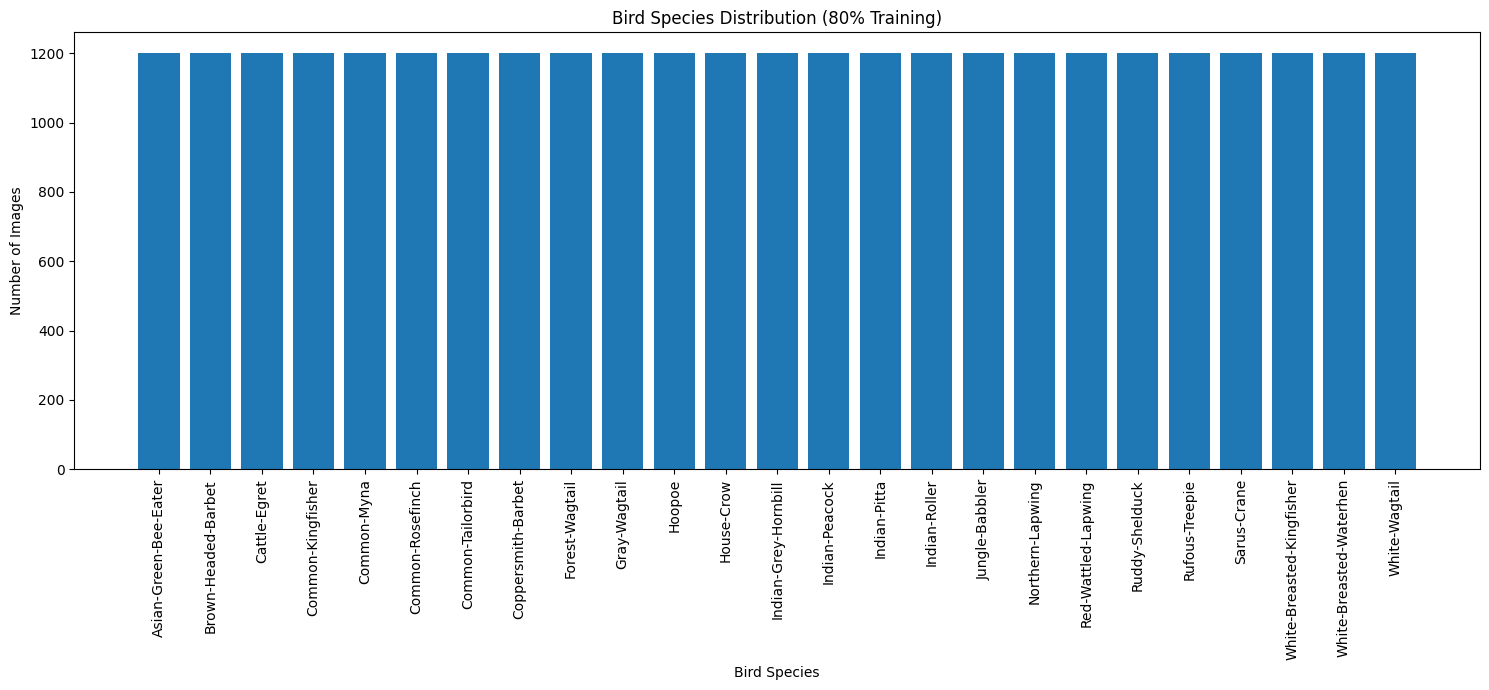


Number of images per class in new VALID_DIR_10:
{'Asian-Green-Bee-Eater': 150, 'Brown-Headed-Barbet': 150, 'Cattle-Egret': 150, 'Common-Kingfisher': 150, 'Common-Myna': 150, 'Common-Rosefinch': 150, 'Common-Tailorbird': 150, 'Coppersmith-Barbet': 150, 'Forest-Wagtail': 150, 'Gray-Wagtail': 150, 'Hoopoe': 150, 'House-Crow': 150, 'Indian-Grey-Hornbill': 150, 'Indian-Peacock': 150, 'Indian-Pitta': 150, 'Indian-Roller': 150, 'Jungle-Babbler': 150, 'Northern-Lapwing': 150, 'Red-Wattled-Lapwing': 150, 'Ruddy-Shelduck': 150, 'Rufous-Treepie': 150, 'Sarus-Crane': 150, 'White-Breasted-Kingfisher': 150, 'White-Breasted-Waterhen': 150, 'White-Wagtail': 150}


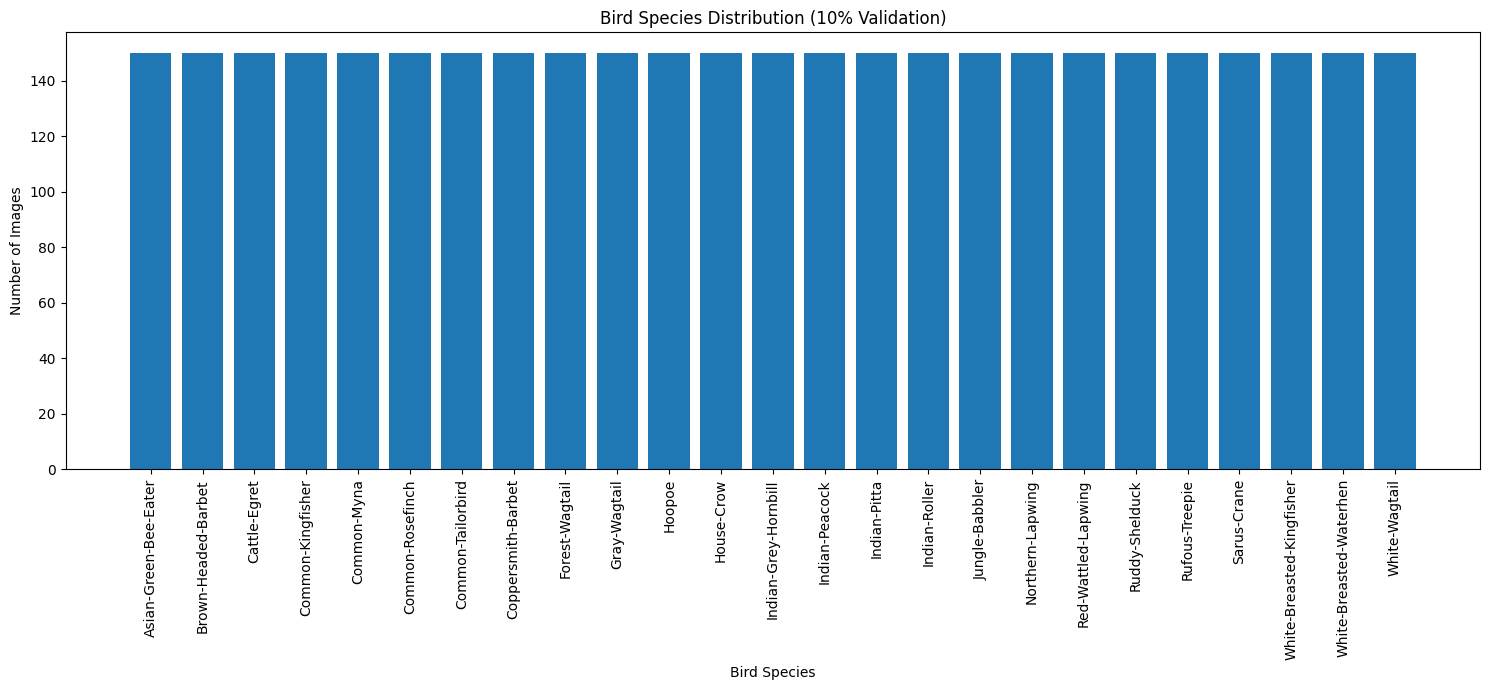


Number of images per class in new TEST_DIR_10:
{'Asian-Green-Bee-Eater': 150, 'Brown-Headed-Barbet': 150, 'Cattle-Egret': 150, 'Common-Kingfisher': 150, 'Common-Myna': 150, 'Common-Rosefinch': 150, 'Common-Tailorbird': 150, 'Coppersmith-Barbet': 150, 'Forest-Wagtail': 150, 'Gray-Wagtail': 150, 'Hoopoe': 150, 'House-Crow': 150, 'Indian-Grey-Hornbill': 150, 'Indian-Peacock': 150, 'Indian-Pitta': 150, 'Indian-Roller': 150, 'Jungle-Babbler': 150, 'Northern-Lapwing': 150, 'Red-Wattled-Lapwing': 150, 'Ruddy-Shelduck': 150, 'Rufous-Treepie': 150, 'Sarus-Crane': 150, 'White-Breasted-Kingfisher': 150, 'White-Breasted-Waterhen': 150, 'White-Wagtail': 150}


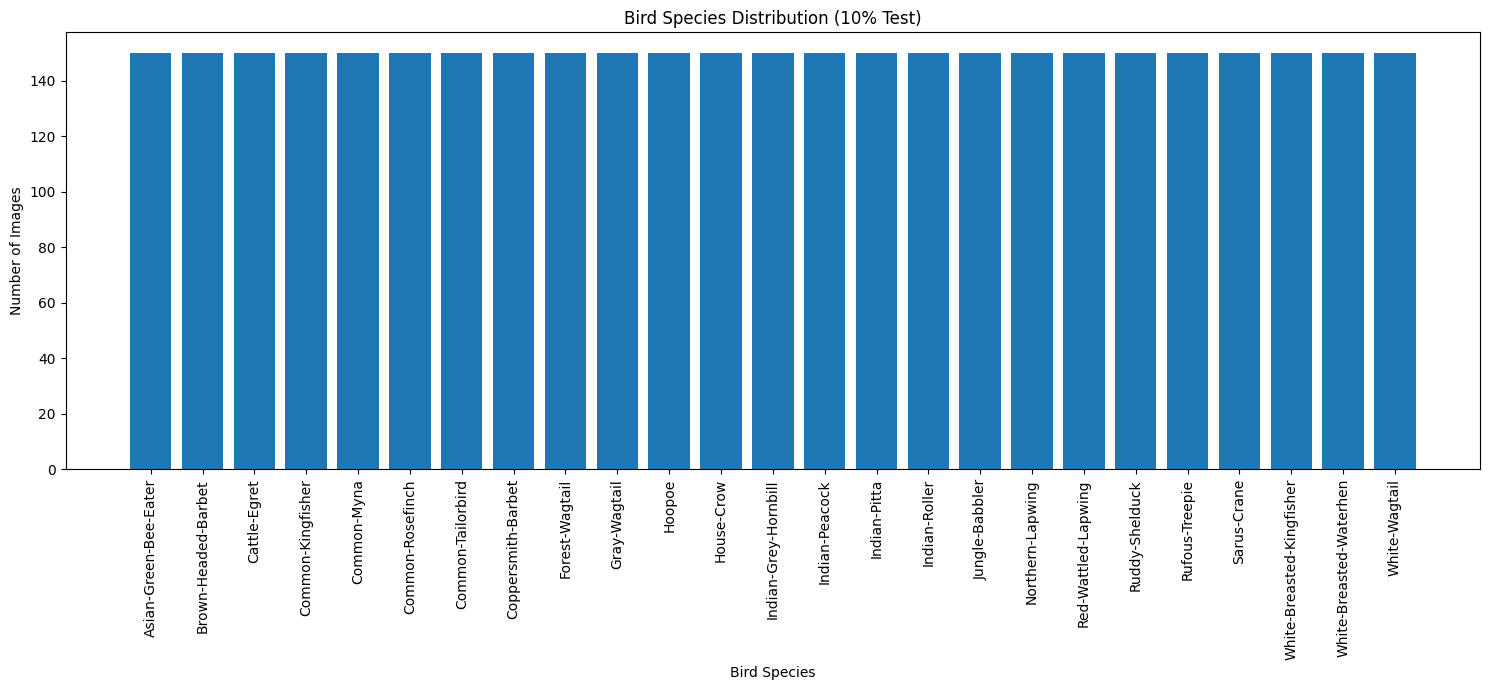


Total number of bird species: 25


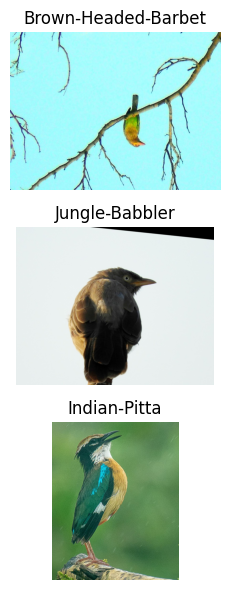

In [ ]:
# --- Dataset Preparation: 80-10-10 Split ---
def create_split_dirs():
    os.makedirs(TRAIN_DIR_80, exist_ok=True)
    os.makedirs(VALID_DIR_10, exist_ok=True)
    os.makedirs(TEST_DIR_10, exist_ok=True)
    print(f"Created directories:\n  {TRAIN_DIR_80}\n  {VALID_DIR_10}\n  {TEST_DIR_10}")

def split_dataset(original_train_dir, original_valid_dir,
                  new_train_dir, new_valid_dir, new_test_dir,
                  subset_ratio=1):
    create_split_dirs()

    all_classes = os.listdir(original_train_dir)

    for bird_class in all_classes:
        print(f"Processing class: {bird_class}")

        os.makedirs(os.path.join(new_train_dir, bird_class), exist_ok=True)
        os.makedirs(os.path.join(new_valid_dir, bird_class), exist_ok=True)
        os.makedirs(os.path.join(new_test_dir, bird_class), exist_ok=True)

        original_train_class_path = os.path.join(original_train_dir, bird_class)
        train_images = os.listdir(original_train_class_path)
        random.shuffle(train_images)

        subset_size_train = int(len(train_images) * subset_ratio)
        subset_train_images = train_images[:subset_size_train] # Subsetting images
        for img_name in subset_train_images:
            shutil.copy(os.path.join(original_train_class_path, img_name),
                        os.path.join(new_train_dir, bird_class, img_name))

        original_valid_class_path = os.path.join(original_valid_dir, bird_class)
        valid_images = os.listdir(original_valid_class_path)
        random.shuffle(valid_images)

        subset_size_valid = int(len(valid_images) * subset_ratio)
        subset_valid_images = valid_images[:subset_size_valid] # Subsetting images

        num_valid_original = len(subset_valid_images)
        split_point = num_valid_original // 2

        new_valid_set = subset_valid_images[:split_point]
        new_test_set = subset_valid_images[split_point:]

        for img_name in new_valid_set:
            shutil.copy(os.path.join(original_valid_class_path, img_name),
                        os.path.join(new_valid_dir, bird_class, img_name))

        for img_name in new_test_set:
            shutil.copy(os.path.join(original_valid_class_path, img_name),
                        os.path.join(new_test_dir, bird_class, img_name))

    print("Dataset splitting complete.")

if not os.path.exists(TEST_DIR_10) or not os.listdir(TEST_DIR_10):
    print("Performing dataset split...")
    split_dataset(TRAIN_DIR, VALID_DIR,
                  TRAIN_DIR_80, VALID_DIR_10, TEST_DIR_10)

else:
    print("Dataset already split and processed. Skipping split.")


train_counts_80_10_10 = count_images_per_class(TRAIN_DIR_80)
valid_counts_80_10_10 = count_images_per_class(VALID_DIR_10)
test_counts_80_10_10 = count_images_per_class(TEST_DIR_10)

print("\nNumber of images per class in new TRAIN_DIR_80:")
print(train_counts_80_10_10)
plot_class_distribution(train_counts_80_10_10, "Bird Species Distribution (80% Training)")

print("\nNumber of images per class in new VALID_DIR_10:")
print(valid_counts_80_10_10)
plot_class_distribution(valid_counts_80_10_10, "Bird Species Distribution (10% Validation)")

print("\nNumber of images per class in new TEST_DIR_10:")
print(test_counts_80_10_10)
plot_class_distribution(test_counts_80_10_10, "Bird Species Distribution (10% Test)")

print(f"\nTotal number of bird species: {len(train_counts_80_10_10)}")
show_sample_images(TRAIN_DIR_80, num_classes_to_show=3)

> ### **Config For Part 1 / Part 2**

In [ ]:
CONFIG = {
    "IMG_WIDTH": 224,
    "IMG_HEIGHT": 224,
    "COLOR_HIST_BINS": (8, 8, 8),
    "SIFT_N_FEATURES": 0,
    "SIFT_DESCRIPTOR_SIZE": 128,
    "GABOR_THETAS_RANGE": 8,
    "GABOR_SIGMAS": (1, 2, 3, 4),
    "GABOR_FREQUENCIES": (0.05, 0.1, 0.2, 0.3, 0.4),
    "GABOR_KERNEL_SIZE": (15, 15),
    "GABOR_GAMMA": 0.5,
    "RF_N_ESTIMATORS": 500,
    "RF_MAX_DEPTH": None,
    "MLP_HIDDEN_LAYERS": (256, 128),
    "MLP_MAX_ITER": 1000,
    # Part 2 specific configurations
    "PCA_N_COMPONENTS_RATIO": 0.9,
    "SELECTKBEST_N_FEATURES_RATIO": 0.7,
    "VARIANCE_THRESHOLD_LEVEL": 0.0,
}

> # **Part 1: Feature Extraction and Traditional ML**

In [ ]:
# --- Image Preprocessing Function ---
def preprocess_image(image_path, target_size=(CONFIG["IMG_WIDTH"], CONFIG["IMG_HEIGHT"])):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}")
        return None
    img = cv2.resize(img, target_size)
    return img

In [ ]:
# --- 1. Feature Extraction Methods ---

def extract_color_histogram(image, bins=CONFIG["COLOR_HIST_BINS"]):
    if image is None: return None
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_sift_features(image, n_features=CONFIG["SIFT_N_FEATURES"], descriptor_size=CONFIG["SIFT_DESCRIPTOR_SIZE"]):
    if image is None: return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=n_features)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    if descriptors is None or len(descriptors) == 0:
        return np.zeros(descriptor_size, dtype=np.float32)

    mean_descriptor = np.mean(descriptors, axis=0)
    return mean_descriptor.flatten()

def generate_gabor_kernels(kernel_size=CONFIG["GABOR_KERNEL_SIZE"],
                           num_thetas=CONFIG["GABOR_THETAS_RANGE"],
                           sigmas=CONFIG["GABOR_SIGMAS"],
                           frequencies=CONFIG["GABOR_FREQUENCIES"],
                           gamma=CONFIG["GABOR_GAMMA"]):
    kernels = []
    for theta_idx in range(num_thetas):
        theta_rad = theta_idx / float(num_thetas) * np.pi
        for sigma in sigmas:
            for frequency in frequencies:
                kernel = cv2.getGaborKernel(ksize=kernel_size, sigma=sigma, theta=theta_rad,
                                            lambd= 1.0 / frequency,
                                            gamma=gamma, psi=0, ktype=cv2.CV_32F)
                kernels.append(kernel)
    print(f"Generated {len(kernels)} Gabor kernels.")
    return kernels

# Pre-generate Gabor kernels once
GABOR_KERNELS_GLOBAL = generate_gabor_kernels()

def extract_gabor_features(image, kernels):
    if image is None: return None
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = []
    for kernel in kernels:
        filtered = cv2.filter2D(gray_image, cv2.CV_32F, kernel)
        features.extend([
            filtered.mean(),
            filtered.std(),
            np.sum(filtered**2) / filtered.size,
        ])
    return np.array(features, dtype=np.float32)

Generated 160 Gabor kernels.


In [ ]:
# 2. Load Data and Extract Features

def load_data_and_extract_features(data_dir, feature_extractor_fn, label_encoder,
                                   feature_name="feature",
                                   target_size=(CONFIG["IMG_WIDTH"], CONFIG["IMG_HEIGHT"])):
    features_list = []
    labels_list = []
    print(f"Loading data from {data_dir} and extracting {feature_name}...")

    processed_images_count = 0
    failed_images_count = 0

    for class_name in label_encoder.classes_:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            try:
                image = preprocess_image(img_path, target_size=target_size)
                if image is not None:
                    feature_vector = feature_extractor_fn(image)
                    if feature_vector is not None and feature_vector.size > 0:
                        features_list.append(feature_vector)
                        labels_list.append(class_name)
                        processed_images_count += 1
                    else:
                        print(f"Warning: Feature extraction failed or returned empty for {img_path}")
                        failed_images_count +=1
                else:
                    failed_images_count += 1
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                failed_images_count += 1

    print(f"Successfully processed {processed_images_count} images, failed to process {failed_images_count} images.")

    features_array = np.array(features_list)
    labels_array = label_encoder.transform(labels_list)

    return features_array, labels_array, label_encoder

In [ ]:
feature_extractors = {
    "ColorHistogram": extract_color_histogram,
    "SIFT": extract_sift_features,
    "Gabor": partial(extract_gabor_features, kernels=GABOR_KERNELS_GLOBAL)
}

ml_models = {
    "SVM": SGDClassifier(loss='hinge', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=CONFIG["RF_N_ESTIMATORS"],
                                         max_depth=CONFIG["RF_MAX_DEPTH"],
                                         random_state=42, n_jobs=-1),
    "MLP": MLPClassifier(hidden_layer_sizes=CONFIG["MLP_HIDDEN_LAYERS"],
                         max_iter=CONFIG["MLP_MAX_ITER"],
                         random_state=42,
                         early_stopping=True, n_iter_no_change=10),
    "NaiveBayes": GaussianNB()
}


--- Processing Feature: ColorHistogram ---
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/train and extracting ColorHistogram...
Successfully processed 30000 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/validation and extracting ColorHistogram...
Successfully processed 3750 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/test and extracting ColorHistogram...
Successfully processed 3749 images, failed to process 1 images.
Shape of ColorHistogram features - Train: (30000, 512), Validation: (3750, 512), Test: (3749, 512)
Training SVM with ColorHistogram features...
    SVM with ColorHistogram - Validation F1: 0.3325, Accuracy: 0.3360
Training RandomForest with ColorHistogram features...
    RandomForest with ColorHistogram - Validation F1: 0.8883, Accuracy: 0.8883
Training MLP with ColorHistogram features..

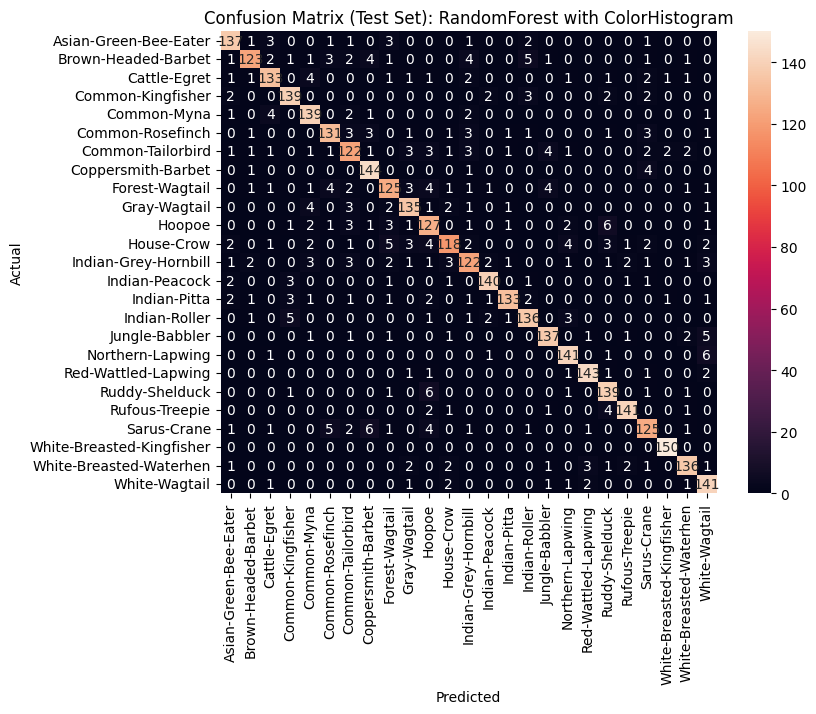


--- Processing Feature: SIFT ---
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/train and extracting SIFT...
Successfully processed 30000 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/validation and extracting SIFT...
Successfully processed 3750 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/test and extracting SIFT...
Successfully processed 3749 images, failed to process 1 images.
Shape of SIFT features - Train: (30000, 128), Validation: (3750, 128), Test: (3749, 128)
Training SVM with SIFT features...
    SVM with SIFT - Validation F1: 0.1416, Accuracy: 0.1475
Training RandomForest with SIFT features...
    RandomForest with SIFT - Validation F1: 0.3327, Accuracy: 0.3389
Training MLP with SIFT features...
    MLP with SIFT - Validation F1: 0.3169, Accuracy: 0.3197
Training NaiveBayes with SIFT features

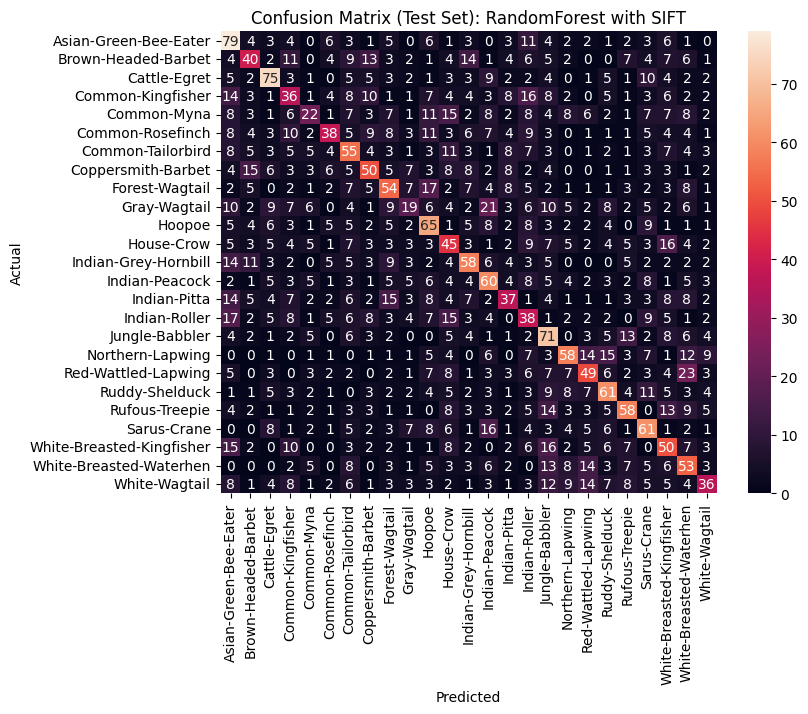


--- Processing Feature: Gabor ---
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/train and extracting Gabor...
Successfully processed 30000 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/validation and extracting Gabor...
Successfully processed 3750 images, failed to process 0 images.
Loading data from /content/drive/MyDrive/Colab_Notebooks/Assignment_4/data_80_10_10/test and extracting Gabor...
Successfully processed 3749 images, failed to process 1 images.
Shape of Gabor features - Train: (30000, 480), Validation: (3750, 480), Test: (3749, 480)
Training SVM with Gabor features...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


    SVM with Gabor - Validation F1: 0.1701, Accuracy: 0.1744
Training RandomForest with Gabor features...
    RandomForest with Gabor - Validation F1: 0.4139, Accuracy: 0.4171
Training MLP with Gabor features...
    MLP with Gabor - Validation F1: 0.2864, Accuracy: 0.2944
Training NaiveBayes with Gabor features...
    NaiveBayes with Gabor - Validation F1: 0.1033, Accuracy: 0.1269

  Best model for Gabor (selected on validation): RandomForest with Val F1: 0.4139
  Evaluating RandomForest on Test Set for Gabor...
    RandomForest with Gabor - Test Accuracy: 0.4161, F1: 0.4136, Train Time: 327.22s
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.49      0.51      0.50       150
      Brown-Headed-Barbet       0.46      0.37      0.41       150
             Cattle-Egret       0.50      0.48      0.49       150
        Common-Kingfisher       0.37      0.48      0.42       150
              Common-Myna       0.46      0.39      0.42     

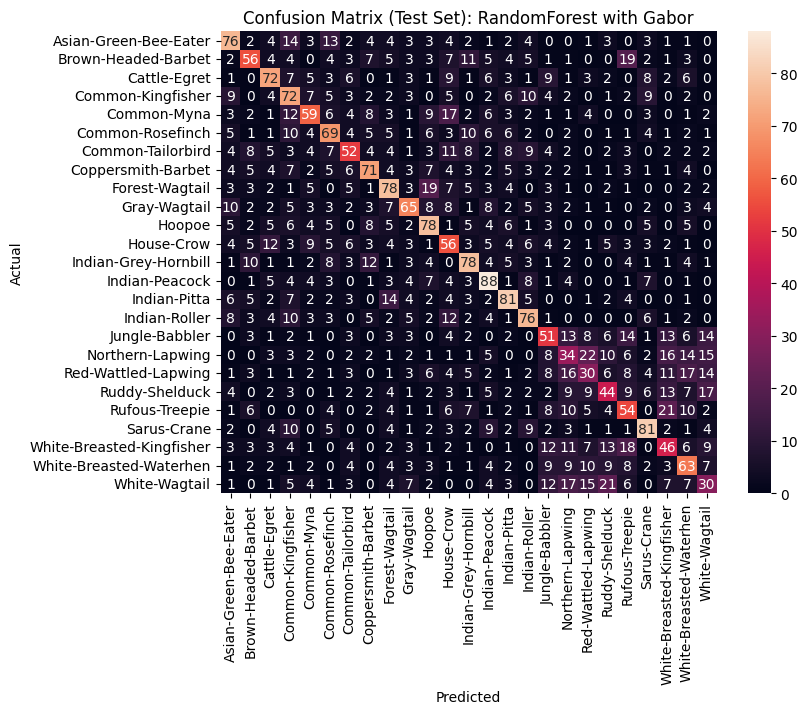


--- Part 1 Results Summary (Best Model per Feature on Test Set) ---
     Part         Feature         Model  Accuracy  Precision    Recall  \
0  Part 1  ColorHistogram  RandomForest  0.895439   0.895952  0.895439   
1  Part 1            SIFT  RandomForest  0.338224   0.340106  0.338224   
2  Part 1           Gabor  RandomForest  0.416111   0.414471  0.416111   

   F1-Score  Train Time (s)  
0  0.895122       94.345716  
1  0.333333      169.741478  
2  0.413638      327.218064  


In [ ]:
# Get all class names for consistent label encoding across train/val/test
all_class_names = sorted(os.listdir(TRAIN_DIR_80))
global_label_encoder = LabelEncoder()
global_label_encoder.fit(all_class_names)

data_dirs = {
    "train": TRAIN_DIR_80,
    "validation": VALID_DIR_10,
    "test": TEST_DIR_10
}

loaded_features_sets = {}
part1_results = []

for feature_name, extractor_fn in feature_extractors.items():
    print(f"\n--- Processing Feature: {feature_name} ---")

    # Load training data
    X_train, y_train, _ = load_data_and_extract_features(
        data_dirs["train"], extractor_fn, global_label_encoder, feature_name
    )
    # Load validation data
    X_valid, y_valid, _ = load_data_and_extract_features(
        data_dirs["validation"], extractor_fn, global_label_encoder, feature_name
    )
    # Load test data
    X_test, y_test, _ = load_data_and_extract_features(
        data_dirs["test"], extractor_fn, global_label_encoder, feature_name
    )

    if X_train.size == 0 or X_valid.size == 0 or X_test.size == 0:
        print(f"Skipping {feature_name} due to insufficient data in train, validation, or test set.")
        continue

    loaded_features_sets[feature_name] = {
        "X_train": X_train, "y_train": y_train,
        "X_valid": X_valid, "y_valid": y_valid,
        "X_test": X_test, "y_test": y_test
    }
    print(f"Shape of {feature_name} features - Train: {X_train.shape}, Validation: {X_valid.shape}, Test: {X_test.shape}")

    best_model_pipeline_part1 = None
    best_val_f1_part1 = -1.0
    best_model_name_part1 = ""
    best_model_train_time_part1 = 0

    for model_name, model_instance in ml_models.items():
        print(f"Training {model_name} with {feature_name} features...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', model_instance)
        ])

        start_time = time.time()
        pipeline.fit(X_train, y_train)
        train_time = time.time() - start_time

        y_pred_valid = pipeline.predict(X_valid)
        val_accuracy = accuracy_score(y_valid, y_pred_valid)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            y_valid, y_pred_valid, average='weighted', zero_division=0
        )

        print(f"    {model_name} with {feature_name} - Validation F1: {val_f1:.4f}, Accuracy: {val_accuracy:.4f}")

        if val_f1 > best_val_f1_part1:
            best_val_f1_part1 = val_f1
            best_model_pipeline_part1 = pipeline
            best_model_name_part1 = model_name
            best_model_train_time_part1 = train_time

    print(f"\n  Best model for {feature_name} (selected on validation): {best_model_name_part1} with Val F1: {best_val_f1_part1:.4f}")
    print(f"  Evaluating {best_model_name_part1} on Test Set for {feature_name}...")

    y_pred_test = best_model_pipeline_part1.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_test, y_pred_test, average='weighted', zero_division=0
    )

    part1_results.append({
        "Part": "Part 1",
        "Feature": feature_name,
        "Model": best_model_name_part1,
        "Accuracy": test_accuracy,
        "Precision": test_precision,
        "Recall": test_recall,
        "F1-Score": test_f1,
        "Train Time (s)": best_model_train_time_part1
    })
    print(f"    {best_model_name_part1} with {feature_name} - Test Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, Train Time: {best_model_train_time_part1:.2f}s")
    print(classification_report(y_test, y_pred_test, target_names=global_label_encoder.classes_, zero_division=0))

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=global_label_encoder.classes_, yticklabels=global_label_encoder.classes_)
    plt.title(f'Confusion Matrix (Test Set): {best_model_name_part1} with {feature_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    plt.close()

df_part1_results = pd.DataFrame(part1_results)
print("\n--- Part 1 Results Summary (Best Model per Feature on Test Set) ---")
print(df_part1_results)

## **Analysis:**

1.   **Feature Performance:**


*   **Color Histogram:** This feature significantly outperformed the others, achieving an F1-score of approximately 0.89 with a RandomForest classifier. This strong performance suggests that the overall color distribution of the bird images is a highly discriminative characteristic for distinguishing between the 25 species. The relatively high dimensionality (512 features) captures a good amount of color information.

*   **Gabor Filters:** Gabor features, which capture texture information at different orientations and scales, yielded the second-best performance with an F1-score of around 0.41 when paired with RandomForest. While this is a considerable drop from Color Histograms, it indicates that texture does provide some level of discriminative power, more so than local keypoints (SIFT) in this setup. The Gabor feature vector was also quite high-dimensional (480 features).

*   **SIFT:** SIFT features performed the poorest, with a maximum F1-score of only 0.33 with RandomForest. SIFT focuses on local, scale-invariant keypoints. The chosen aggregation method (mean of descriptors for all keypoints in an image) might be too simplistic and could be losing crucial spatial or statistical information. For fine-grained classification like bird species, where subtle differences in patterns and shapes matter, a simple mean descriptor might not be sufficient. It's possible that the birds have too much intra-class variation in pose for SIFT to find consistently matchable keypoints across images of the same species without more sophisticated techniques.



2.   **Model Performance:**


*   **Random Forest:** This model consistently emerged as the top performer across all three feature types based on validation F1-scores. This is a common outcome as Random Forests are robust to noisy data, handle high-dimensional features well, are less prone to overfitting than individual decision trees.
*   **Other Models (SVM, MLP, Naive Bayes):** For Color Histograms, MLP was the next best model (validation F1 ~0.77), suggesting that a neural network could learn useful non-linear patterns, though not outperforming RandomForest in this instance. SVM and Naive Bayes performed significantly worse. For SIFT and Gabor features, while RandomForest was still the best, the overall performance of all models was low. This strongly suggests that the primary limitation was the descriptive power of these features for this task, rather than the choice of the classifier itself. Naive Bayes, with its strong feature independence assumption, generally performed the worst, which is expected for complex image features that are often correlated.



3.   **Computational Cost (Training Time):**


*   RandomForest, being an ensemble method, took the longest, especially with higher-dimensional Gabor features (327s) and SIFT (169s). Even with 512-dimensional Color Histograms, RandomForest trained in a more moderate 94s.
*   MLP training time was significant for Color Histograms (likely due to the number of iterations needed for convergence on 512 features) but would also be considerable for Gabor and SIFT.
*   SVM (SGDClassifier) and Naive Bayes are generally faster to train, but their performance was not competitive.



## **Comments and Interpretations:**



*   The results highlight that for this bird classification task, global color information (Color Histogram) is a much stronger signal than local keypoints (SIFT with mean aggregation) or general texture (Gabor filters).
*   The relatively poor performance of SIFT might be due to the high intra-class variability in bird poses and appearances, or the chosen aggregation method.
*   Gabor filters provided some useful texture information, but it wasn't enough to compete with color.
*   RandomForest's consistent top performance underscores its utility as a strong baseline classifier for various feature types.
*   The performance gap between Color Histograms and the other two features is substantial, suggesting that simply extracting more complex local features doesn't guarantee better results if they don't capture the most discriminative aspects of the classes or if they are not processed/aggregated effectively.

> # **Part 2: Principal Component Analysis and Feature Selection**


--- Processing Feature: ColorHistogram for Part 2 ---
  Shape of ColorHistogram after initial scaling & VarThresh: Train (30000, 509), Valid (3750, 509), Test (3749, 509)
  Applying PCA to ColorHistogram features...
 Shape after PCA: Train (30000, 458), Valid (3750, 458), Test (3749, 458)
    Training and validating SVM with PCA-reduced ColorHistogram features...
      SVM with ColorHistogram+PCA - Validation F1: 0.3214, Accuracy: 0.3237
    Training and validating RandomForest with PCA-reduced ColorHistogram features...
      RandomForest with ColorHistogram+PCA - Validation F1: 0.8038, Accuracy: 0.8032
    Training and validating MLP with PCA-reduced ColorHistogram features...
      MLP with ColorHistogram+PCA - Validation F1: 0.7164, Accuracy: 0.7165
    Training and validating NaiveBayes with PCA-reduced ColorHistogram features...
      NaiveBayes with ColorHistogram+PCA - Validation F1: 0.0673, Accuracy: 0.0859

  Best model for ColorHistogram+PCA (selected on validation): Random

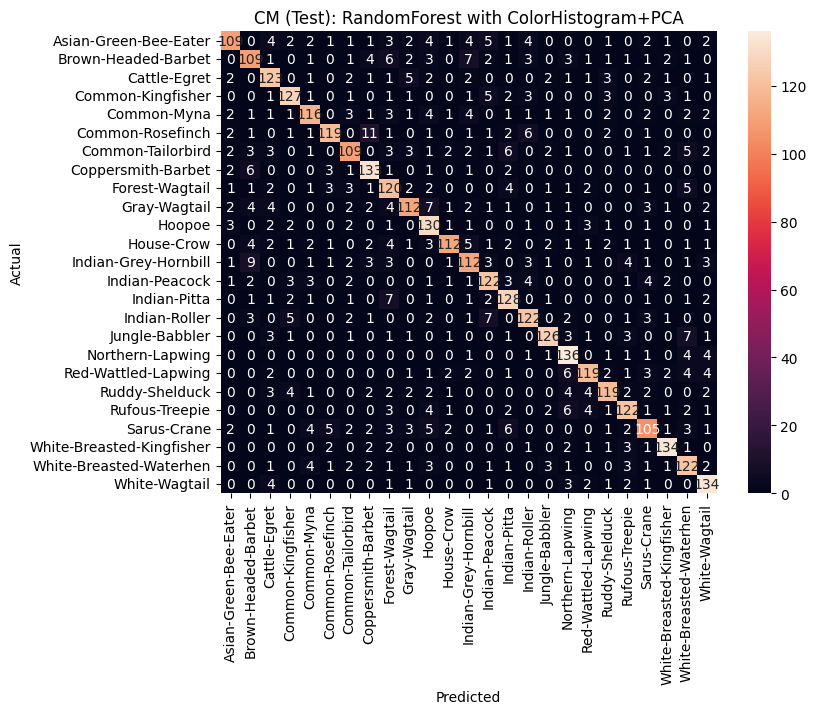

  Applying SelectKBest to ColorHistogram features...
 Shape after SelectKBest: Train (30000, 356), Valid (3750, 356), Test (3749, 356)
    Training and validating SVM with SelectKBest-reduced ColorHistogram features...
      SVM with ColorHistogram+SelectKBest - Validation F1: 0.3248, Accuracy: 0.3267
    Training and validating RandomForest with SelectKBest-reduced ColorHistogram features...
      RandomForest with ColorHistogram+SelectKBest - Validation F1: 0.8868, Accuracy: 0.8869
    Training and validating MLP with SelectKBest-reduced ColorHistogram features...
      MLP with ColorHistogram+SelectKBest - Validation F1: 0.7644, Accuracy: 0.7637
    Training and validating NaiveBayes with SelectKBest-reduced ColorHistogram features...
      NaiveBayes with ColorHistogram+SelectKBest - Validation F1: 0.1652, Accuracy: 0.1680

  Best model for ColorHistogram+SelectKBest (selected on validation): RandomForest with Val F1: 0.8868
 Evaluating RandomForest on Test Set for ColorHistogram+S

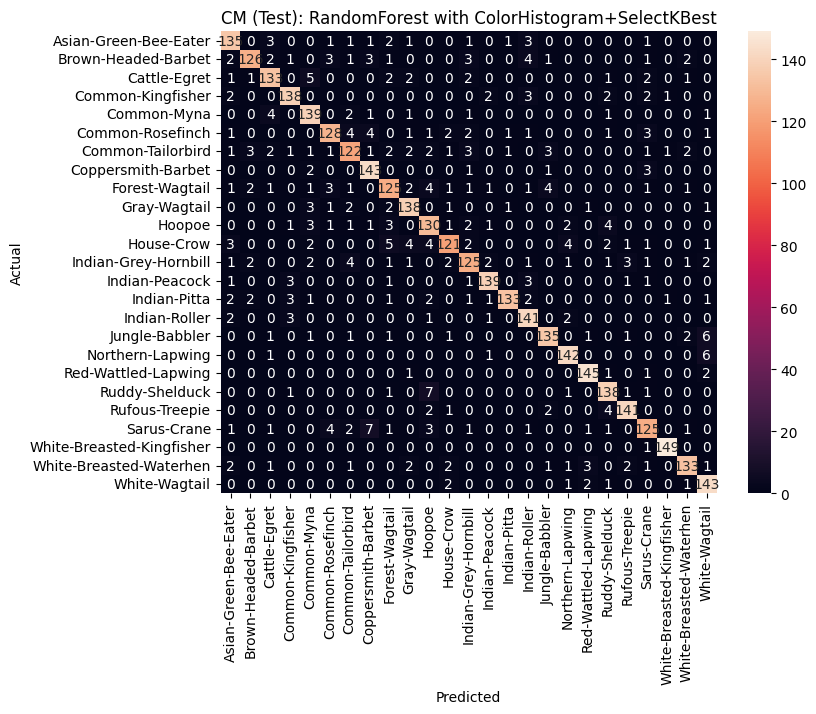


--- Processing Feature: SIFT for Part 2 ---
  Shape of SIFT after initial scaling & VarThresh: Train (30000, 128), Valid (3750, 128), Test (3749, 128)
  Applying PCA to SIFT features...
 Shape after PCA: Train (30000, 115), Valid (3750, 115), Test (3749, 115)
    Training and validating SVM with PCA-reduced SIFT features...
      SVM with SIFT+PCA - Validation F1: 0.1496, Accuracy: 0.1525
    Training and validating RandomForest with PCA-reduced SIFT features...
      RandomForest with SIFT+PCA - Validation F1: 0.3120, Accuracy: 0.3227
    Training and validating MLP with PCA-reduced SIFT features...
      MLP with SIFT+PCA - Validation F1: 0.2779, Accuracy: 0.2837
    Training and validating NaiveBayes with PCA-reduced SIFT features...
      NaiveBayes with SIFT+PCA - Validation F1: 0.1392, Accuracy: 0.1491

  Best model for SIFT+PCA (selected on validation): RandomForest with Val F1: 0.3120
 Evaluating RandomForest on Test Set for SIFT+PCA...
      RandomForest with SIFT+PCA - Test 

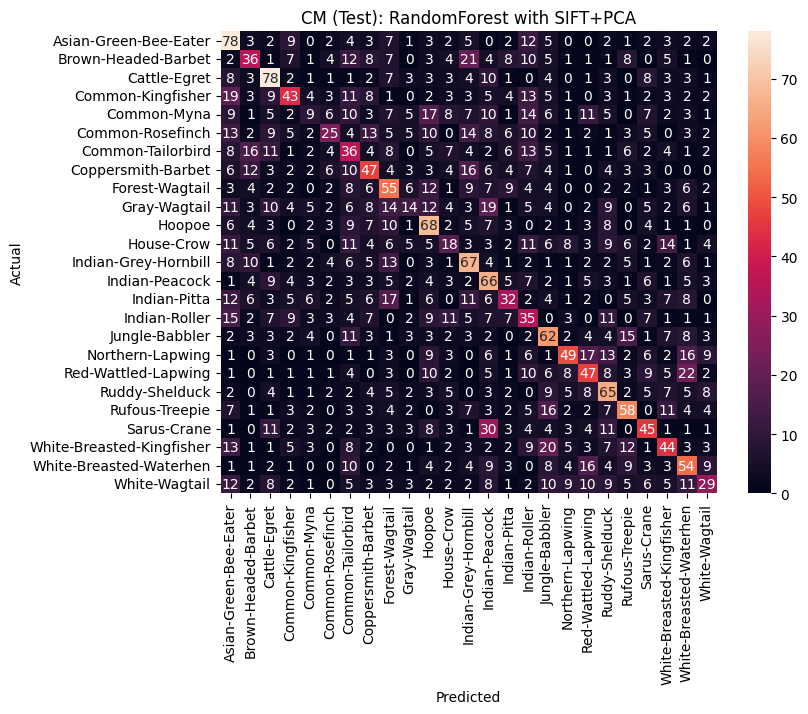

  Applying SelectKBest to SIFT features...
 Shape after SelectKBest: Train (30000, 89), Valid (3750, 89), Test (3749, 89)
    Training and validating SVM with SelectKBest-reduced SIFT features...
      SVM with SIFT+SelectKBest - Validation F1: 0.1194, Accuracy: 0.1467
    Training and validating RandomForest with SelectKBest-reduced SIFT features...
      RandomForest with SIFT+SelectKBest - Validation F1: 0.2897, Accuracy: 0.2960
    Training and validating MLP with SelectKBest-reduced SIFT features...
      MLP with SIFT+SelectKBest - Validation F1: 0.2780, Accuracy: 0.2800
    Training and validating NaiveBayes with SelectKBest-reduced SIFT features...
      NaiveBayes with SIFT+SelectKBest - Validation F1: 0.0901, Accuracy: 0.1259

  Best model for SIFT+SelectKBest (selected on validation): RandomForest with Val F1: 0.2897
 Evaluating RandomForest on Test Set for SIFT+SelectKBest...
      RandomForest with SIFT+SelectKBest - Test Accuracy: 0.3121, F1: 0.3078, Time: 144.21s
       

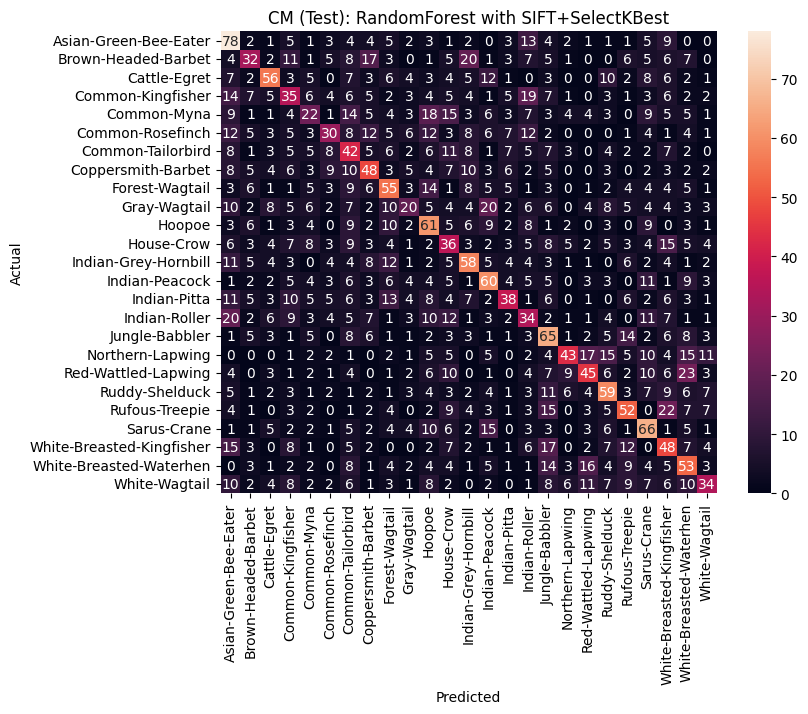


--- Processing Feature: Gabor for Part 2 ---
  Shape of Gabor after initial scaling & VarThresh: Train (30000, 480), Valid (3750, 480), Test (3749, 480)
  Applying PCA to Gabor features...
 Shape after PCA: Train (30000, 432), Valid (3750, 432), Test (3749, 432)
    Training and validating SVM with PCA-reduced Gabor features...
      SVM with Gabor+PCA - Validation F1: 0.2037, Accuracy: 0.2059
    Training and validating RandomForest with PCA-reduced Gabor features...
      RandomForest with Gabor+PCA - Validation F1: 0.3540, Accuracy: 0.3595
    Training and validating MLP with PCA-reduced Gabor features...
      MLP with Gabor+PCA - Validation F1: 0.2925, Accuracy: 0.2987
    Training and validating NaiveBayes with PCA-reduced Gabor features...
      NaiveBayes with Gabor+PCA - Validation F1: 0.0932, Accuracy: 0.1101

  Best model for Gabor+PCA (selected on validation): RandomForest with Val F1: 0.3540
 Evaluating RandomForest on Test Set for Gabor+PCA...
      RandomForest with Gab

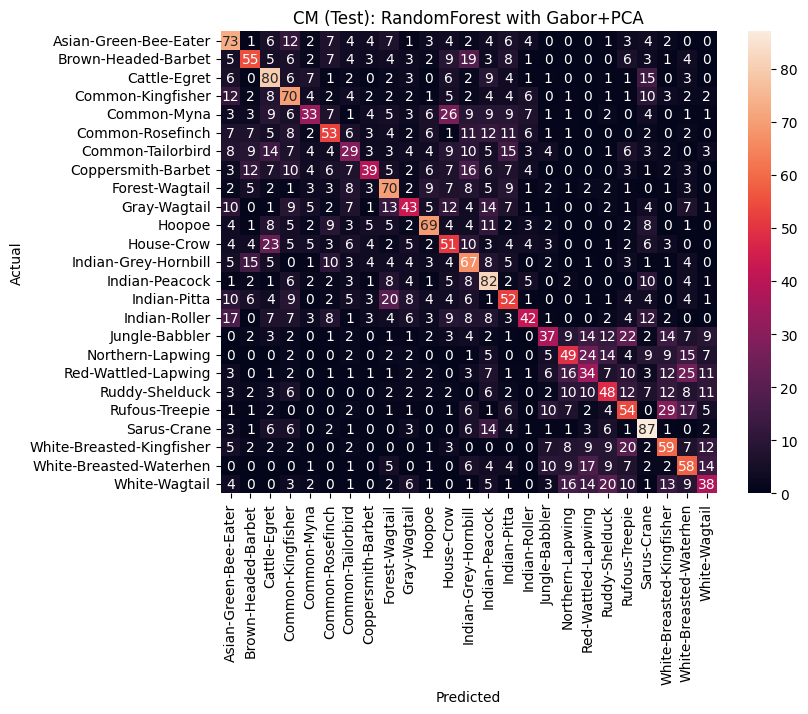

  Applying SelectKBest to Gabor features...
 Shape after SelectKBest: Train (30000, 336), Valid (3750, 336), Test (3749, 336)
    Training and validating SVM with SelectKBest-reduced Gabor features...
      SVM with Gabor+SelectKBest - Validation F1: 0.1650, Accuracy: 0.1669
    Training and validating RandomForest with SelectKBest-reduced Gabor features...
      RandomForest with Gabor+SelectKBest - Validation F1: 0.4114, Accuracy: 0.4152
    Training and validating MLP with SelectKBest-reduced Gabor features...
      MLP with Gabor+SelectKBest - Validation F1: 0.3053, Accuracy: 0.3099
    Training and validating NaiveBayes with SelectKBest-reduced Gabor features...
      NaiveBayes with Gabor+SelectKBest - Validation F1: 0.1062, Accuracy: 0.1291

  Best model for Gabor+SelectKBest (selected on validation): RandomForest with Val F1: 0.4114
 Evaluating RandomForest on Test Set for Gabor+SelectKBest...
      RandomForest with Gabor+SelectKBest - Test Accuracy: 0.4124, F1: 0.4094, Time: 

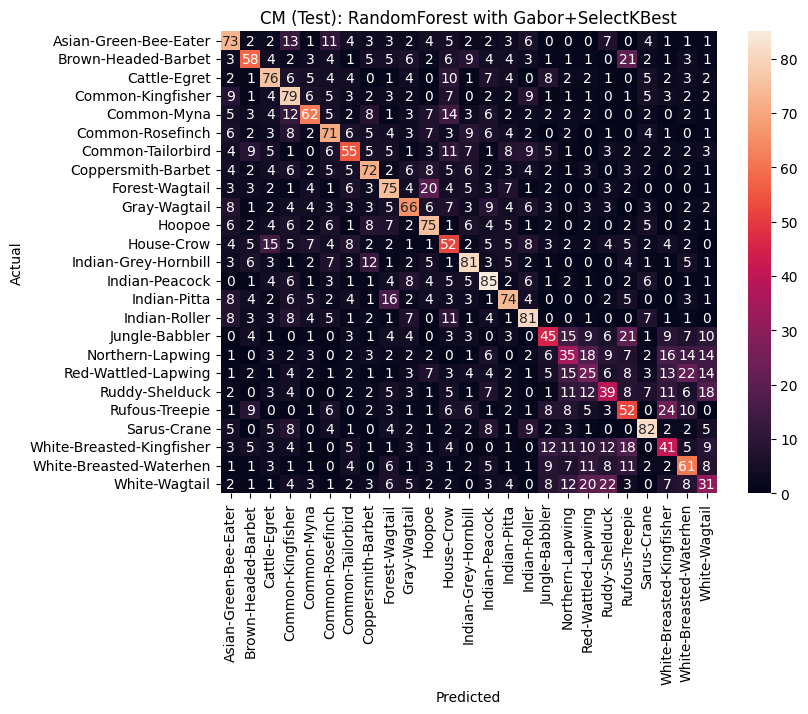


--- Part 2 Results Summary (Best Model per Feature+DR on Test Set) ---
     Part                       Feature         Model  Accuracy  Precision  \
0  Part 2          ColorHistogram + PCA  RandomForest  0.805548   0.808168   
1  Part 2  ColorHistogram + SelectKBest  RandomForest  0.898106   0.898702   
2  Part 2                    SIFT + PCA  RandomForest  0.309416   0.305438   
3  Part 2            SIFT + SelectKBest  RandomForest  0.312083   0.317935   
4  Part 2                   Gabor + PCA  RandomForest  0.365964   0.370314   
5  Part 2           Gabor + SelectKBest  RandomForest  0.412377   0.409548   

     Recall  F1-Score  Train Time (s)  
0  0.805548  0.805252      321.835632  
1  0.898106  0.897798      110.411784  
2  0.309416  0.298830      176.437954  
3  0.312083  0.307820      144.210933  
4  0.365964  0.360356      343.769447  
5  0.412377  0.409427      281.978892  

--- Combined Traditional ML Results (Part 1 & 2 - Best Models on Test Set) ---
     Part            

In [ ]:
part2_results = []

for feature_name, data_dict in loaded_features_sets.items():
    print(f"\n--- Processing Feature: {feature_name} for Part 2 ---")
    X_train_orig, y_train = data_dict["X_train"], data_dict["y_train"]
    X_valid_orig, y_valid = data_dict["X_valid"], data_dict["y_valid"]
    X_test_orig, y_test = data_dict["X_test"], data_dict["y_test"]

    # 1. Initial Scaling (applied to each feature set before DR)

    initial_scaler = StandardScaler()
    X_train_scaled_pre_dr = initial_scaler.fit_transform(X_train_orig)
    X_valid_scaled_pre_dr = initial_scaler.transform(X_valid_orig)
    X_test_scaled_pre_dr = initial_scaler.transform(X_test_orig)


    # 2. Variance Threshold (to remove constant features after scaling)

    var_thresh = VarianceThreshold(threshold=CONFIG["VARIANCE_THRESHOLD_LEVEL"])
    X_train_processed = var_thresh.fit_transform(X_train_scaled_pre_dr)
    X_valid_processed = var_thresh.transform(X_valid_scaled_pre_dr)
    X_test_processed = var_thresh.transform(X_test_scaled_pre_dr)

    print(f"  Shape of {feature_name} after initial scaling & VarThresh: Train {X_train_processed.shape}, Valid {X_valid_processed.shape}, Test {X_test_processed.shape}")


    # 3. Define Dimensionality Reduction Methods

    dim_reduction_methods_config = {}
    num_features_after_vt = X_train_processed.shape[1]
    num_samples_train = X_train_processed.shape[0]

    # PCA Configuration
    # If ratio is float (0 to 1), it's interpreted as variance to keep.
    # If int, it's number of components. We'll use ratio to determine number of components.
    # n_components for PCA must be <= min(n_samples, n_features)
    max_pca_components = min(num_samples_train, num_features_after_vt)
    if isinstance(CONFIG["PCA_N_COMPONENTS_RATIO"], float) and 0 < CONFIG["PCA_N_COMPONENTS_RATIO"] < 1:
        n_components_pca_val = int(num_features_after_vt * CONFIG["PCA_N_COMPONENTS_RATIO"])
    else: # If it's an integer or 1.0
        n_components_pca_val = int(CONFIG["PCA_N_COMPONENTS_RATIO"] * num_features_after_vt) if CONFIG["PCA_N_COMPONENTS_RATIO"] <=1 else int(CONFIG["PCA_N_COMPONENTS_RATIO"])


    n_components_pca_val = max(1, n_components_pca_val)
    n_components_pca_val = min(max_pca_components, n_components_pca_val) # Cap by max possible

    if n_components_pca_val > 0:
        dim_reduction_methods_config["PCA"] = PCA(n_components=n_components_pca_val, random_state=42)


    # SelectKBest Configuration
    # k for SelectKBest must be <= n_features
    max_kbest_features = num_features_after_vt
    n_features_kbest_val = int(num_features_after_vt * CONFIG["SELECTKBEST_N_FEATURES_RATIO"])
    n_features_kbest_val = max(1, n_features_kbest_val)
    n_features_kbest_val = min(max_kbest_features, n_features_kbest_val) # Cap by max possible

    if n_features_kbest_val > 0:
        k_param = 'all' if n_features_kbest_val >= num_features_after_vt else n_features_kbest_val
        if k_param != 'all' and k_param > 0 : # only add if k is a valid number of features to select
            dim_reduction_methods_config["SelectKBest"] = SelectKBest(score_func=f_classif, k=k_param)
        elif k_param == 'all' and num_features_after_vt > 0 :
             actual_k_for_all = num_features_after_vt
             if actual_k_for_all > 0:
                 dim_reduction_methods_config["SelectKBest_all"] = SelectKBest(score_func=f_classif, k=actual_k_for_all)


   # 4. Apply DR methods and Train Models

    for dr_name, dr_method_instance in dim_reduction_methods_config.items():
        print(f"  Applying {dr_name} to {feature_name} features...")
        X_train_reduced, X_valid_reduced, X_test_reduced = None, None, None

        if dr_name == "PCA":
            X_train_reduced = dr_method_instance.fit_transform(X_train_processed)
            X_valid_reduced = dr_method_instance.transform(X_valid_processed)
            X_test_reduced = dr_method_instance.transform(X_test_processed)
        elif "SelectKBest" in dr_name:
            X_train_reduced = dr_method_instance.fit_transform(X_train_processed, y_train)
            X_valid_reduced = dr_method_instance.transform(X_valid_processed)
            X_test_reduced = dr_method_instance.transform(X_test_processed)
        else:
            continue

        print(f" Shape after {dr_name}: Train {X_train_reduced.shape}, Valid {X_valid_reduced.shape}, Test {X_test_reduced.shape}")

        best_model_pipeline_part2 = None
        best_val_f1_part2 = -1.0
        best_model_name_part2 = ""
        best_model_train_time_part2 = 0

        for model_name, model_instance in ml_models.items():
            pipeline = Pipeline([
                ('scaler_post_dr', StandardScaler()),
                ('classifier', model_instance)
            ])

            print(f"    Training and validating {model_name} with {dr_name}-reduced {feature_name} features...")
            start_time = time.time()
            pipeline.fit(X_train_reduced, y_train)
            train_time = time.time() - start_time

            y_pred_valid_dr = pipeline.predict(X_valid_reduced)
            val_accuracy_dr = accuracy_score(y_valid, y_pred_valid_dr)
            val_precision_dr, val_recall_dr, val_f1_dr, _ = precision_recall_fscore_support(
                y_valid, y_pred_valid_dr, average='weighted', zero_division=0
            )
            print(f"      {model_name} with {feature_name}+{dr_name} - Validation F1: {val_f1_dr:.4f}, Accuracy: {val_accuracy_dr:.4f}")

            if val_f1_dr > best_val_f1_part2:
                best_val_f1_part2 = val_f1_dr
                best_model_pipeline_part2 = pipeline
                best_model_name_part2 = model_name
                best_model_train_time_part2 = train_time

        print(f"\n  Best model for {feature_name}+{dr_name} (selected on validation): {best_model_name_part2} with Val F1: {best_val_f1_part2:.4f}")
        print(f" Evaluating {best_model_name_part2} on Test Set for {feature_name}+{dr_name}...")

        y_pred_test_dr = best_model_pipeline_part2.predict(X_test_reduced)
        test_accuracy_dr = accuracy_score(y_test, y_pred_test_dr)
        test_precision_dr, test_recall_dr, test_f1_dr, _ = precision_recall_fscore_support(
            y_test, y_pred_test_dr, average='weighted', zero_division=0
        )

        part2_results.append({
            "Part": "Part 2",
            "Feature": f"{feature_name} + {dr_name}",
            "Model": best_model_name_part2,
            "Accuracy": test_accuracy_dr,
            "Precision": test_precision_dr,
            "Recall": test_recall_dr,
            "F1-Score": test_f1_dr,
            "Train Time (s)": best_model_train_time_part2
        })
        print(f"      {best_model_name_part2} with {feature_name}+{dr_name} - Test Accuracy: {test_accuracy_dr:.4f}, F1: {test_f1_dr:.4f}, Time: {best_model_train_time_part2:.2f}s")
        print(classification_report(y_test, y_pred_test_dr, target_names=global_label_encoder.classes_, zero_division=0))

        cm_dr = confusion_matrix(y_test, y_pred_test_dr)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm_dr, annot=True, fmt='d', xticklabels=global_label_encoder.classes_, yticklabels=global_label_encoder.classes_)
        plt.title(f'CM (Test): {best_model_name_part2} with {feature_name}+{dr_name}')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        plt.close()

df_part2_results = pd.DataFrame(part2_results)
print("\n--- Part 2 Results Summary (Best Model per Feature+DR on Test Set) ---")
print(df_part2_results)

# Combine all traditional ML results
df_all_traditional_ml_results = pd.concat([df_part1_results, df_part2_results], ignore_index=True)
print("\n--- Combined Traditional ML Results (Part 1 & 2 - Best Models on Test Set) ---")
print(df_all_traditional_ml_results.sort_values(by="F1-Score", ascending=False))

## **Analysis:**

1.   **Performance with Color Histogram Features:**


*   **Original (Part 1 - 512 features):** RandomForest F1-score: 0.8951, Train Time: 94.35s.

*   **PCA (458 features):**

    -    The best model was RandomForest, achieving an F1-score of 0.8053. This is a significant decrease of ~0.09 compared to using the original features.

    -    Dimensionality was reduced from 509 to 458.

    -    Surprisingly, the training time for RandomForest increased substantially to 321.84s. This is counter-intuitive as fewer features usually lead to faster training. It's possible the dense, transformed nature of PCA components made the RandomForest algorithm's splitting process more computationally intensive.


*   **SelectKBest (356 features):**

     -    RandomForest was again the best, with an F1-score of 0.8978. This is a slight improvement over the original features.

     -    Dimensionality was reduced more significantly, from 509 to 356.

     -    Training time was 110.41s, a slight increase compared to the original but considerably less than with PCA-transformed features.


*   **Interpretation for Color Histogram:** SelectKBest proved to be beneficial, slightly improving the already strong performance of Color Histograms while reducing features by about 30%. This suggests that some of the original color histogram bins were redundant or less informative, and removing them helped. PCA, despite retaining 90% variance, was detrimental, likely losing some discriminative information or creating a less favorable feature space for the RandomForest classifier.



2.   **Performance with SIFT Features:**


*   **Original (Part 1 - 128 features):** RandomForest F1-score: 0.3333, Train Time: 169.74s.

*   **PCA (115 features):**

    -    RandomForest F1-score: 0.2988 (decrease).

    -    Dimensionality reduced from 128 to 115.

    -    Training time: 176.44s (slight increase).


*   **SelectKBest (89 features):**

     -    RandomForest F1-score: 0.3078 (decrease, but slightly better than PCA).

     -    Dimensionality reduced from 128 to 89.

     -    Training time: 144.21s (decrease).


*   **Interpretation for SIFT:** Neither PCA nor SelectKBest improved the performance of SIFT features; in fact, both led to a decrease in F1-score. SIFT features were already the weakest in Part 1, and dimensionality reduction did not salvage their utility for this classification task. SelectKBest offered a modest reduction in training time. The poor performance suggests the inherent information in the mean SIFT descriptors was insufficient, regardless of DR.




3.   **Performance with Gabor Features:**


*   **Original (Part 1 - 480 features):** RandomForest F1-score: 0.4136, Train Time: 327.22s.

*   **PCA (432 features):**

    -    RandomForest F1-score: 0.3604 (decrease).

    -    Dimensionality reduced from 480 to 432.

    -    Training time: 343.77s (slight increase).


*   **SelectKBest (336 features):**

     -    RandomForest F1-score: 0.4094 (slight decrease, almost on par with original).

     -    Dimensionality reduced from 480 to 336.

     -    Training time: 281.98s (notable decrease).


*   **Interpretation for Gabor:** Similar to SIFT, PCA degraded the performance of Gabor features. SelectKBest, however, resulted in a performance very close to the original Gabor features but with a significant reduction in dimensionality (by 30%) and a corresponding decrease in training time. This indicates that many Gabor features were highly correlated or less discriminative, and SelectKBest effectively identified a more compact, almost equally useful subset.



4.    **Overall Comparison and Model Consistency:**



*   **Best Overall Performance:** The combination of ColorHistogram + SelectKBest + RandomForest yielded the highest F1-score (0.8978) among all traditional ML experiments in Part 1 and Part 2. This was marginally better than using the original ColorHistogram features.

*   **PCA vs. SelectKBest:**
    -    PCA consistently resulted in lower F1-scores compared to both the original features and features selected by SelectKBest, across all three feature types. The increase in training time post-PCA for RandomForest was also an unexpected and undesirable outcome.

    -    SelectKBest was generally more effective. For Color Histograms, it slightly improved F1-score. For Gabor and SIFT, while it didn't improve upon the original F1-score, the performance degradation was less severe than with PCA, and it often came with the benefit of reduced training times due to fewer features.

*   **Why SelectKBest might be better here:** SelectKBest preserves the original features, merely discarding those deemed less relevant by the scoring function (f_classif). This can be advantageous if the original features have direct, interpretable meaning and some are highly discriminative. PCA, on the other hand, creates new, orthogonal components that are linear combinations of original features. While this can reduce noise and multicollinearity, the transformation might obscure important discriminative patterns or distribute them in a way that requires more components (and thus variance) to capture, potentially losing subtle but crucial information if the *n_components_ratio* isn't perfectly tuned or if the underlying data structure doesn't align well with PCA's assumptions for classification.

*   **Model Choice:** RandomForest consistently remained the best-performing classifier across all feature sets and dimensionality reduction techniques, reaffirming its robustness and effectiveness for this type of tabular image feature data.



5.    **Impact on Training Time:**

*   SelectKBest generally led to reduced (Gabor, SIFT) or slightly increased (ColorHistogram) training times for RandomForest, which is expected when working with fewer features.

*   PCA, counter-intuitively, led to increased training times for RandomForest in all cases, despite the reduction in the number of input features. This suggests the transformed features might be denser or have characteristics that make the tree-building process in RandomForest more computationally demanding.



6.    **Conclusions for Part 2:**

*   Dimensionality reduction is not universally beneficial. Its effectiveness is highly dependent on the nature of the features and the DR method employed.

*   For this dataset and feature set, SelectKBest was a more promising DR technique than PCA. It particularly shone with Color Histograms, achieving the best overall result while reducing feature dimensionality. For Gabor features, it maintained performance while significantly reducing feature count and training time.

*   PCA, with the 90% variance retention strategy, was detrimental to performance for all feature types and unexpectedly increased training times for the best model (RandomForest). This suggests that either the retained components lost crucial discriminative information or the transformed feature space was less suitable for the classifier.

*   The strong performance of Color Histograms, especially with SelectKBest, continues to highlight the importance of color information for this bird classification task.

*   SIFT and Gabor features, even after DR, remained significantly less effective than Color Histograms, indicating their limited discriminative power in their current form for this specific problem.

*  RandomForest's consistent superiority underscores its strength as a general-purpose classifier for these types of image-derived features.

# **Part 3: Fine-Tuning Pretrained CNN Models**
Selecting three pretrained CNN (Convolutional Neural Network) models and fine-tuning them to adapt the given dataset. With loss graphs and auto stopping mechanism.

In [15]:
import os
import random
import shutil
import time
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import numpy as np


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


**Data Transformations**

For each dataset (training, validation, testing), different image preprocessing steps (transformations) are defined.

In [ ]:
# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)), # scales images to a fixed size (224x224 pixels), necessary for the CNNs to fit the input size
        transforms.RandomHorizontalFlip(), # (training only): randomly flips image horizontally, data augmentation technique, makes model more robust to horizontal variations
        transforms.ToTensor(), # converts image from NumPy array to a PyTorch tensor and normalizes values ​​to the range 0–1
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

data_dirs = {
    'train': TRAIN_DIR_80,
    'val': VALID_DIR_10,
    'test': TEST_DIR_10
}
# ImageFolder is a PyTorch ready function. It takes the images in the folder you specify and gives them labels according to the subfolder name.
# Images in a specific folder are taken and then a specific transformation is applied
image_datasets = {x: ImageFolder(data_dirs[x], data_transforms[x]) for x in ['train', 'val', 'test']}

# num_workers: number of threads are used to load data. This speeds up the loading process.
dataloaders = {
    x: DataLoader(
        image_datasets[x],
        batch_size=32,
        shuffle=True,
        num_workers=2,
        pin_memory=True  #Faster data transfer with GPU
    ) for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


**Training**

This part is used to train and validate a deep learning model with PyTorch. It also includes early stopping.

In [ ]:
from torch.amp import autocast, GradScaler

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    # model: PyTorch model to be trained
    # criterion: Loss function
    # optimizer: Algorithm used to update the model
    # scheduler: System that adjusts the learning rate according to epochs
    # num_epochs: Total number of epochs to be taken (default 25)
    # patience: How many epochs to stop early if the validation loss does not improve
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # weights of the model with the lowest validation loss are kept here
    best_loss = float('inf')

    train_losses, val_losses = [], []
    epochs_no_improve = 0 # val loss keeps track of how many epochs have been counted without recovery, for "early stopping"

    scaler = GradScaler(device='cuda')  

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss, running_corrects = 0.0, 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad() # clears previous gradients

                with torch.set_grad_enabled(phase == 'train'): # gradient calculation is performed only during the training phase
                  with autocast(device_type='cuda'):
                      outputs = model(inputs) # prediction is made
                      _, preds = torch.max(outputs, 1) # class with the highest probability is taken
                      loss = criterion(outputs, labels) # loss is calculated based on actual and estimated values

                  if phase == 'train':
                      scaler.scale(loss).backward()       # AMP: loss.backward instead
                      scaler.step(optimizer)             # AMP: optimizer.step instead
                      scaler.update()                    # AMP: scaler update

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase] # gives the average loss in that phase
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # accuracy is calculated

            if phase == 'train':
                scheduler.step() # adjusts the learning rate according to the training loss
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
                if epoch_loss < best_loss: # is val loss improve?
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1

        print(f'Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}')

        # If there is no improvement over the epoch of patience, training is stopped !!!!! =>>>> early stopping
        if epochs_no_improve == patience:
            print("Early stopping triggered.")
            break

    model.load_state_dict(best_model_wts) # weights of the best model are loaded back into the model
    time_elapsed = time.time() - since
    print(f'Training complete in {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')

    return model, train_losses, val_losses


**Evaluating**

The purpose of this code is to evaluate the overall performance of the trained PyTorch model on test or validation data. That is, it measures whether the model has learned really well using various statistical metrics.

In [25]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch

def evaluate_model(model, dataloader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy()) # Actual tags and predictions are grouped into separate lists
            all_labels.extend(labels.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nEvaluation Metrics:")
    print(f"  Accuracy : {accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall   : {recall * 100:.2f}%")
    print(f"  F1-Score : {f1 * 100:.2f}%")

    # Detailed per-class report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    return accuracy, precision, recall, f1


**The loss values** ​​generated during training and validation are **plotted** (the learning process of the model is visualized).

In [26]:
def plot_losses(train_losses, val_losses, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


**Fine Tuning**

The aim is to subsequently customize (train) different deep learning models (such as VGG, EfficientNet, ResNet) with the fine-tuning method and test their performance after training.

In [27]:
def fine_tune_model(model_name, base_model):
    print(f'\n--- Fine-tuning {model_name} ---')
    base_model.to(device)

    # This part makes the last layers of the model suitable for the target dataset.
    # Because models trained on ImageNet are usually trained on 1000 classes. Our number of classes is much less.
    if model_name.startswith("VGG"):
        num_ftrs = base_model.classifier[0].in_features if isinstance(base_model.classifier, nn.Sequential) else base_model.classifier.in_features
        base_model.classifier = nn.Sequential( # classifier part is the last classifier layer
            nn.Linear(num_ftrs, 256), # Input → 256 neurons
            nn.ReLU(),
            nn.Dropout(0.4), # 40% dropout (prevents over-fitting)
            nn.Linear(256, len(class_names)) # 256 → output as many as the number of classes
        )
    elif model_name.startswith("EfficientNet"):
      linear_layer = None
      for layer in base_model.classifier:
          if isinstance(layer, nn.Linear):
              linear_layer = layer
              break
      num_ftrs = linear_layer.in_features
      base_model.classifier = nn.Sequential(
          nn.Linear(num_ftrs, 256),
          nn.ReLU(),
          nn.Dropout(0.4),
          nn.Linear(256, len(class_names))
      )
    else:
        num_ftrs = base_model.fc.in_features # fc: Fully connected (last) layer. This is redefined as many times as the target class number.
        base_model.fc = nn.Linear(num_ftrs, len(class_names))

    base_model = base_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0005)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model, train_losses, val_losses = train_model(base_model, criterion, optimizer, exp_lr_scheduler, num_epochs=10, patience=5)
    print("Accuracy Results for Test Data")
    accuracy_results = evaluate_model(model, dataloaders['test'], class_names)
    plot_losses(train_losses, val_losses, model_name)


**3 Different Models Training**

To complete the task, we had to choose models carefully because we were working on Google Colab for free, which gaves us a T4 GPU with a limit of 4 hours and 10 minutes. The dataset was around 1 MB in size, with 37,000 items and 25 classes. So, the models needed to be both fast and accurate for multi-class classification.

- **ResNet18:** It is a lightweight and fast model that uses skip connections to avoid vanishing gradients. It is good for limited resources and performs well on deep learning tasks.

- **VGG16:** This model has a simple and regular architecture with 16 layers. It is easy to fine-tune and often gives good results, especially for image classification problems.

- **EfficientNet-B0:** It is a newer model that balances speed and accuracy using compound scaling. It gives high performance with fewer parameters, making it suitable for limited GPU usage.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.1MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 156MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 123MB/s] 



--- Fine-tuning ResNet18 ---

Epoch 1/20
----------
Train Loss: 0.5967 | Val Loss: 0.4424

Epoch 2/20
----------
Train Loss: 0.3001 | Val Loss: 0.3633

Epoch 3/20
----------
Train Loss: 0.2291 | Val Loss: 0.3695

Epoch 4/20
----------
Train Loss: 0.1687 | Val Loss: 0.3459

Epoch 5/20
----------
Train Loss: 0.1362 | Val Loss: 0.3382

Epoch 6/20
----------
Train Loss: 0.1328 | Val Loss: 0.3215

Epoch 7/20
----------
Train Loss: 0.1143 | Val Loss: 0.3396

Epoch 8/20
----------
Train Loss: 0.0440 | Val Loss: 0.1448

Epoch 9/20
----------
Train Loss: 0.0196 | Val Loss: 0.1359

Epoch 10/20
----------
Train Loss: 0.0094 | Val Loss: 0.1258

Epoch 11/20
----------
Train Loss: 0.0082 | Val Loss: 0.1259

Epoch 12/20
----------
Train Loss: 0.0057 | Val Loss: 0.1265

Epoch 13/20
----------
Train Loss: 0.0039 | Val Loss: 0.1163

Epoch 14/20
----------
Train Loss: 0.0033 | Val Loss: 0.1114

Epoch 15/20
----------
Train Loss: 0.0028 | Val Loss: 0.1119

Epoch 16/20
----------
Train Loss: 0.0025 | Val 

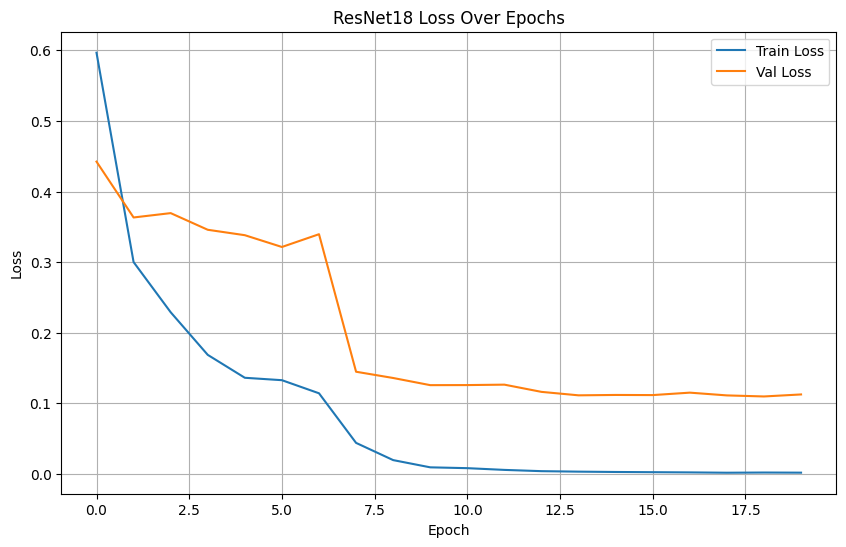


--- Fine-tuning VGG16 ---

Epoch 1/20
----------
Train Loss: 2.8635 | Val Loss: 2.4799

Epoch 2/20
----------
Train Loss: 2.2519 | Val Loss: 1.9669

Epoch 3/20
----------
Train Loss: 1.7857 | Val Loss: 1.5288

Epoch 4/20
----------
Train Loss: 1.4259 | Val Loss: 1.1692

Epoch 5/20
----------
Train Loss: 1.1347 | Val Loss: 1.0304

Epoch 6/20
----------
Train Loss: 0.9629 | Val Loss: 0.9629

Epoch 7/20
----------
Train Loss: 0.8357 | Val Loss: 0.9028

Epoch 8/20
----------
Train Loss: 0.5293 | Val Loss: 0.5969

Epoch 9/20
----------
Train Loss: 0.4412 | Val Loss: 0.5698

Epoch 10/20
----------
Train Loss: 0.3852 | Val Loss: 0.5480

Epoch 11/20
----------
Train Loss: 0.3350 | Val Loss: 0.5500

Epoch 12/20
----------
Train Loss: 0.3098 | Val Loss: 0.5176

Epoch 13/20
----------
Train Loss: 0.2738 | Val Loss: 0.5073

Epoch 14/20
----------
Train Loss: 0.2356 | Val Loss: 0.5388

Epoch 15/20
----------
Train Loss: 0.2042 | Val Loss: 0.5157

Epoch 16/20
----------
Train Loss: 0.1922 | Val Los

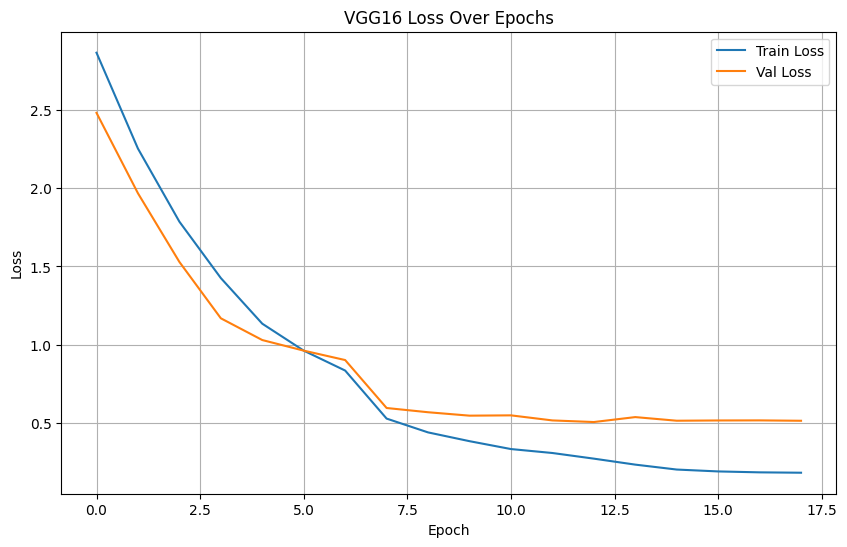


--- Fine-tuning EfficientNet-B0 ---


AttributeError: 'Dropout' object has no attribute 'in_features'

In [ ]:
models_to_train = {
    "ResNet18": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
    "VGG16": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "EfficientNet-B0": models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
}


for name, model in models_to_train.items():
    fine_tune_model(name, model)


**Summary of Experiment 1 Results:**
I used 50% of the data for a *fast first trial*. I couldn’t test the "EfficientNet-B0" model due to an error. Total time: 77 + 86 min.

**ResNet18 Fine-Tuning Results**
- Accuracy: 96.96%
- Precision / Recall / F1-score: all around 96.9%, showing high performance.
- Train vs Val Loss: Training loss decreased smoothly, and validation loss improved until epoch 19 (lowest = 0.1098).

Comment:
- ResNet18 performed very well, with balanced and stable metrics across all bird classes.
- The model did not overfit even though the training loss got very low.
- Even with 50% data, it learned features effectively.

**VGG16 Fine-Tuning Results**
- Accuracy: 83.09%
- F1-score: 83.28%
- Train vs Val Loss: Validation loss improved until epoch 13, but then stopped improving.

**!!!Early Stopping Triggered at Epoch 18**

Early stopping was used to prevent overfitting because validation loss did not improve for several epochs.

This could happen due to:
- Too few training samples (only 50% used).
- VGG16 being a larger model, needing more data to generalize.

**Detailed Insight:**

- Some classes like Indian-Grey-Hornbill (f1: 0.54) or Common-Tailorbird (f1: 0.67) were **harder to predict**.
- This suggests the model struggled with less distinctive features or similar-looking species.


--- Fine-tuning EfficientNet-B0 ---

Epoch 1/10
----------
Train Loss: 0.4092 | Val Loss: 0.1258

Epoch 2/10
----------
Train Loss: 0.1463 | Val Loss: 0.0799

Epoch 3/10
----------
Train Loss: 0.1068 | Val Loss: 0.0609

Epoch 4/10
----------
Train Loss: 0.0884 | Val Loss: 0.0604

Epoch 5/10
----------
Train Loss: 0.0879 | Val Loss: 0.1098

Epoch 6/10
----------
Train Loss: 0.0663 | Val Loss: 0.0740

Epoch 7/10
----------
Train Loss: 0.0610 | Val Loss: 0.0525

Epoch 8/10
----------
Train Loss: 0.0251 | Val Loss: 0.0278

Epoch 9/10
----------
Train Loss: 0.0118 | Val Loss: 0.0225

Epoch 10/10
----------
Train Loss: 0.0068 | Val Loss: 0.0204
Training complete in 82m 21s
Accuracy Results for Test Data

Evaluation Metrics:
  Accuracy : 99.28%
  Precision: 99.29%
  Recall   : 99.28%
  F1-Score : 99.28%

Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.99      1.00      1.00       150
      Brown-Headed-Barbet       

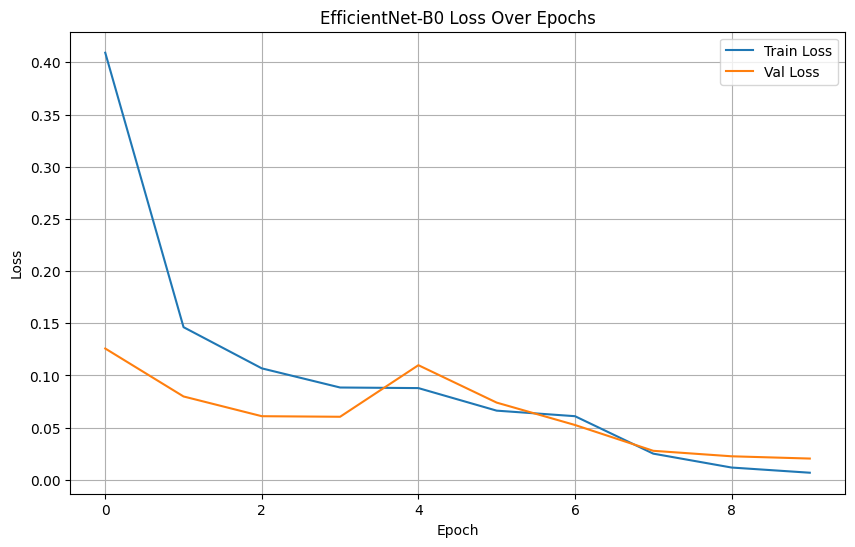


--- Fine-tuning VGG16 ---

Epoch 1/10
----------
Train Loss: 2.4821 | Val Loss: 1.7834

Epoch 2/10
----------
Train Loss: 1.4906 | Val Loss: 1.1100

Epoch 3/10
----------
Train Loss: 1.0541 | Val Loss: 0.8620

Epoch 4/10
----------
Train Loss: 0.8086 | Val Loss: 0.7442

Epoch 5/10
----------
Train Loss: 0.6554 | Val Loss: 0.6345

Epoch 6/10
----------
Train Loss: 0.5027 | Val Loss: 0.5246

Epoch 7/10
----------
Train Loss: 0.4289 | Val Loss: 0.5151

Epoch 8/10
----------
Train Loss: 0.2259 | Val Loss: 0.3063

Epoch 9/10
----------
Train Loss: 0.1636 | Val Loss: 0.2926

Epoch 10/10
----------
Train Loss: 0.1304 | Val Loss: 0.2865
Training complete in 106m 12s
Accuracy Results for Test Data

Evaluation Metrics:
  Accuracy : 92.53%
  Precision: 92.85%
  Recall   : 92.53%
  F1-Score : 92.63%

Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.97      0.95      0.96       150
      Brown-Headed-Barbet       0.92     

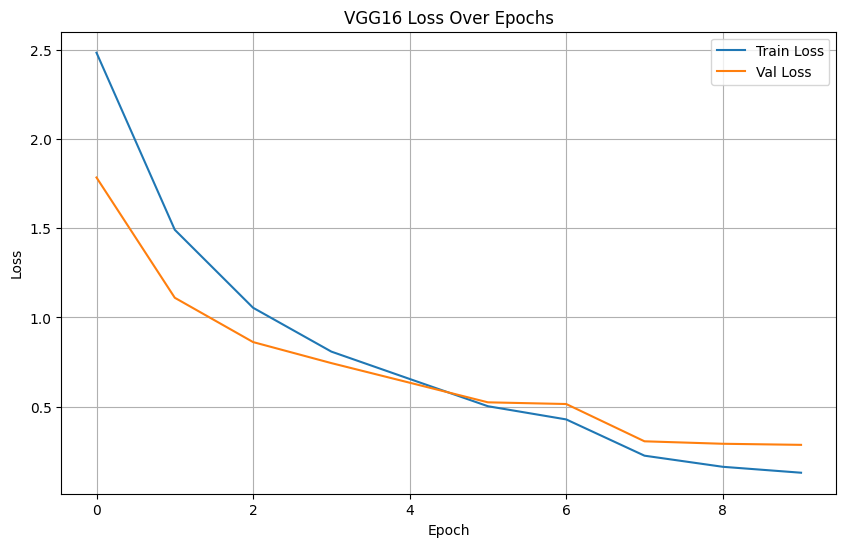


--- Fine-tuning ResNet18 ---

Epoch 1/10
----------
Train Loss: 0.4754 | Val Loss: 0.4178

Epoch 2/10
----------
Train Loss: 0.2504 | Val Loss: 0.2517

Epoch 3/10
----------
Train Loss: 0.1875 | Val Loss: 0.2453

Epoch 4/10
----------
Train Loss: 0.1505 | Val Loss: 0.2650

Epoch 5/10
----------


In [ ]:
models_to_train = {
    "EfficientNet-B0": models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT),
    "VGG16": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "ResNet18": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
}

for name, model in models_to_train.items():
    fine_tune_model(name, model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 72.7MB/s]



--- Fine-tuning ResNet18 ---

Epoch 1/10
----------
Train Loss: 0.4792 | Val Loss: 0.3591

Epoch 2/10
----------
Train Loss: 0.2423 | Val Loss: 0.2368

Epoch 3/10
----------
Train Loss: 0.1880 | Val Loss: 0.2727

Epoch 4/10
----------
Train Loss: 0.1589 | Val Loss: 0.2386

Epoch 5/10
----------
Train Loss: 0.1259 | Val Loss: 0.1809

Epoch 6/10
----------
Train Loss: 0.1034 | Val Loss: 0.2246

Epoch 7/10
----------
Train Loss: 0.1004 | Val Loss: 0.2016

Epoch 8/10
----------
Train Loss: 0.0284 | Val Loss: 0.0801

Epoch 9/10
----------
Train Loss: 0.0127 | Val Loss: 0.0670

Epoch 10/10
----------
Train Loss: 0.0082 | Val Loss: 0.0650
Training complete in 79m 28s
Accuracy Results for Test Data

Evaluation Metrics:
  Accuracy : 97.71%
  Precision: 97.72%
  Recall   : 97.71%
  F1-Score : 97.71%

Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.99      0.99      0.99       150
      Brown-Headed-Barbet       0.97   

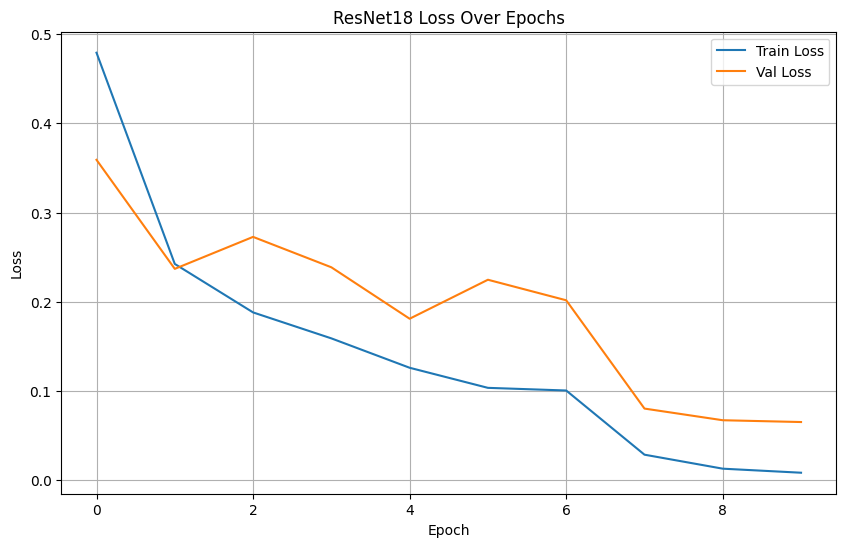

In [22]:
models_to_train = {
    # "EfficientNet-B0": models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT),
    # "VGG16": models.vgg16(weights=models.VGG16_Weights.DEFAULT),
    "ResNet18": models.resnet18(weights=models.ResNet18_Weights.DEFAULT),
}

for name, model in models_to_train.items():
    fine_tune_model(name, model)

**Experiment 2 – Full Dataset, Reduced Epochs**

In this experiment, we used the *Full Dataset* instead of a subset. Because of Colab's time limitations with the free T4 GPU, we reduced the number of epochs from 20 to 10. However, even with this change, the training time was still too long, so we had to run the models in parts. We trained the first two models (EfficientNet-B0 and VGG16) together and trained the last model (ResNet18) separately.

**EfficientNet-B0**
- Training Time: 82 minutes 21 seconds
- Test Accuracy: 99.28%
- Precision, Recall, F1-Score: All above 99%

> Comments:
*EfficientNet-B0 gave excellent results.* The validation loss decreased steadily and remained low. The final metrics show high accuracy across all 25 bird classes, with very balanced precision and recall. This model *performed the best* in this experiment.

**VGG16**
- Training Time: 106 minutes 12 seconds
- Test Accuracy: 92.53%
- Precision, Recall, F1-Score: Around 92–93%

> Comments:
VGG16 showed decent performance but was clearly weaker than EfficientNet-B0. Although the loss decreased over time, the accuracy stayed lower. Some classes had much lower scores than others (e.g., Indian Grey Hornbill), which suggests that *this model may need further tuning or more training time*.

**ResNet18**
- Training Time: 79 minutes 28 seconds
- Test Accuracy: 97.71%
- Precision, Recall, F1-Score: All 97.71%


> Comments:
ResNet18 delivered very strong performance, clearly *better than VGG16 and close to EfficientNet-B0*. The training and validation losses decreased steadily across all epochs. The model showed consistent high accuracy across nearly all classes. The lowest-performing class (Indian Grey Hornbill) still had a solid F1-score of 0.94, which indicates strong generalization.



**Final Summary (Experiment 2)**

| Model            | Accuracy | Training Time   | Key Strength                        |
|------------------|----------|------------------|--------------------------------------|
| **EfficientNet-B0** | 99.28% | 82 min 21 sec   | Highest accuracy, best overall       |
| **ResNet18**         | 97.71% | 79 min 28 sec   | Fast, consistent, very reliable      |
| **VGG16**            | 92.53% | 106 min 12 sec  | Acceptable, but weaker than others   |


# **Part 4: Training Randomly Weighted CNN Models**
Assigning random weights to the CNN models that we selected for third part and train the models with the given dataset.

**Scratch Training Function**

In [ ]:
def train_from_scratch(model_name, base_model):
    print(f'\n--- Training from Scratch: {model_name} ---')
    base_model.to(device)

    # The last layer of the model is adjusted according to the number of target classes.
    if model_name.startswith("VGG"):
        num_ftrs = base_model.classifier[0].in_features if isinstance(base_model.classifier, nn.Sequential) else base_model.classifier.in_features
        base_model.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, len(class_names))
        ).to(device)
    elif model_name.startswith("EfficientNet"):
        linear_layer = None
        for layer in base_model.classifier:
            if isinstance(layer, nn.Linear):
                linear_layer = layer
                break
        num_ftrs = linear_layer.in_features
        base_model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, len(class_names))
        ).to(device)  

    else:  # ResNet
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Linear(num_ftrs, len(class_names)).to(device)

    # Optional compile
    try:
        base_model = torch.compile(base_model)
    except Exception as e:
        print("torch.compile not supported in this environment. Skipping compile step.")


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(base_model.parameters(), lr=0.0005)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Call train_model with AMP support
    model, train_losses, val_losses = train_model(base_model, criterion, optimizer, exp_lr_scheduler, num_epochs=20, patience=5, use_amp=True) 

    print("Accuracy Results for Test Data")
    accuracy_results = evaluate_model(model, dataloaders['test'], class_names)
    plot_losses(train_losses, val_losses, f"{model_name} (Scratch)")

    return accuracy_results


**Definition of Scratch Models**

In [26]:
scratch_models = {
    "EfficientNet-B0": models.efficientnet_b0(weights=None),
    "VGG16": models.vgg16(weights=None),
    "ResNet18": models.resnet18(weights=None),  # pretrained=False is also okey
}


**Scratch Models Training**


--- Training from Scratch: EfficientNet-B0 ---

Epoch 1/20
----------


W0531 13:05:52.540000 191 torch/_inductor/utils.py:1137] [0/1] Not enough SMs to use max_autotune_gemm mode


Train Loss: 2.6879 | Val Loss: 2.2165

Epoch 2/20
----------
Train Loss: 2.1673 | Val Loss: 1.9661

Epoch 3/20
----------
Train Loss: 1.9047 | Val Loss: 1.7937

Epoch 4/20
----------
Train Loss: 1.7270 | Val Loss: 1.5645

Epoch 5/20
----------
Train Loss: 1.5520 | Val Loss: 1.4109

Epoch 6/20
----------
Train Loss: 1.3484 | Val Loss: 1.2944

Epoch 7/20
----------
Train Loss: 1.1820 | Val Loss: 1.0512

Epoch 8/20
----------
Train Loss: 0.9087 | Val Loss: 0.8721

Epoch 9/20
----------
Train Loss: 0.8249 | Val Loss: 0.8444

Epoch 10/20
----------
Train Loss: 0.7899 | Val Loss: 0.8287

Epoch 11/20
----------
Train Loss: 0.7563 | Val Loss: 0.8102

Epoch 12/20
----------
Train Loss: 0.7270 | Val Loss: 0.7945

Epoch 13/20
----------
Train Loss: 0.6881 | Val Loss: 0.7845

Epoch 14/20
----------
Train Loss: 0.6618 | Val Loss: 0.7655

Epoch 15/20
----------
Train Loss: 0.6278 | Val Loss: 0.7560

Epoch 16/20
----------
Train Loss: 0.6288 | Val Loss: 0.7611

Epoch 17/20
----------
Train Loss: 0.62

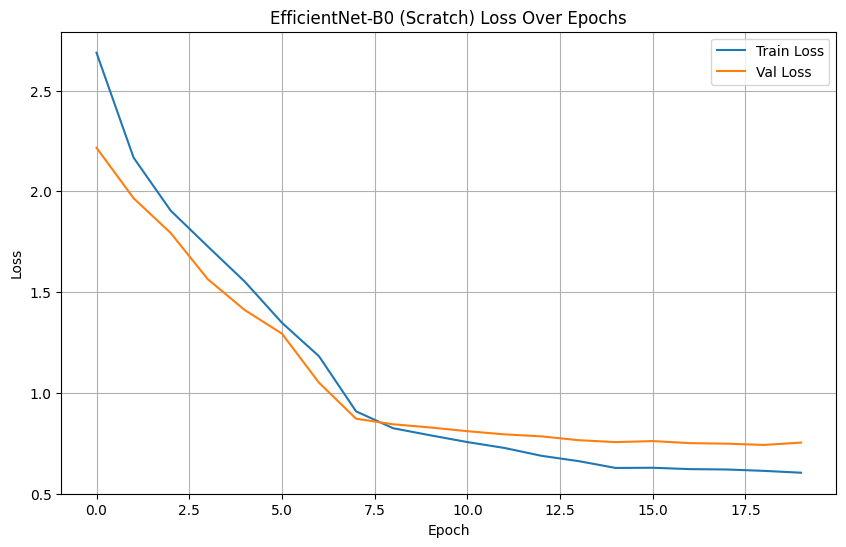


--- Training from Scratch: VGG16 ---

Epoch 1/20
----------
Train Loss: 3.2246 | Val Loss: 3.2191

Epoch 2/20
----------
Train Loss: 3.2195 | Val Loss: 3.2190

Epoch 3/20
----------
Train Loss: 3.2193 | Val Loss: 3.2188

Epoch 4/20
----------
Train Loss: 3.2192 | Val Loss: 3.2190

Epoch 5/20
----------
Train Loss: 3.2192 | Val Loss: 3.2189

Epoch 6/20
----------
Train Loss: 3.2192 | Val Loss: 3.2189

Epoch 7/20
----------
Train Loss: 3.2192 | Val Loss: 3.2189

Epoch 8/20
----------
Train Loss: 3.2189 | Val Loss: 3.2189
Early stopping triggered.
Training complete in 33m 58s
Accuracy Results for Test Data

Evaluation Metrics:
  Accuracy : 4.00%
  Precision: 0.16%
  Recall   : 4.00%
  F1-Score : 0.31%

Classification Report:
                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.00      0.00      0.00        75
      Brown-Headed-Barbet       0.00      0.00      0.00        75
             Cattle-Egret       0.00      0.00      0.00        7

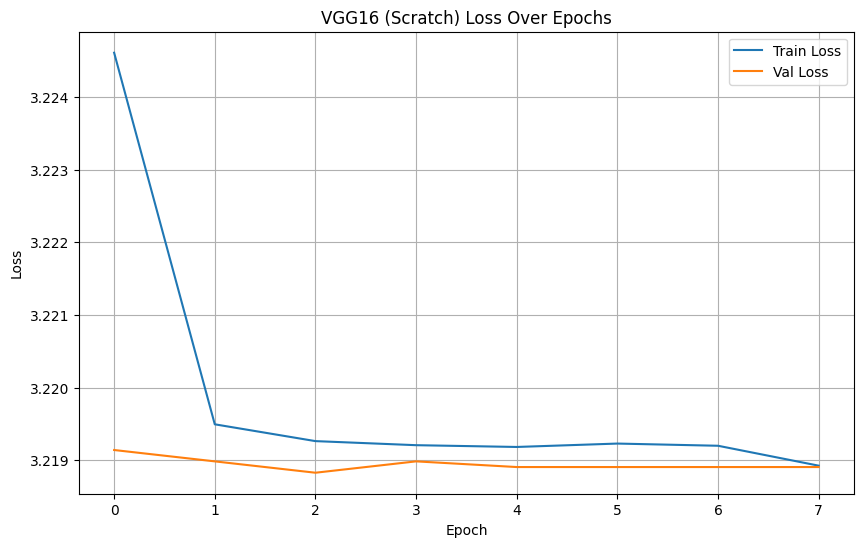


--- Training from Scratch: ResNet18 ---

Epoch 1/20
----------
Train Loss: 2.3024 | Val Loss: 2.0818

Epoch 2/20
----------
Train Loss: 1.7153 | Val Loss: 1.7318

Epoch 3/20
----------
Train Loss: 1.3583 | Val Loss: 1.9738

Epoch 4/20
----------
Train Loss: 1.0718 | Val Loss: 1.2700

Epoch 5/20
----------
Train Loss: 0.8537 | Val Loss: 1.5225

Epoch 6/20
----------
Train Loss: 0.7273 | Val Loss: 1.0417

Epoch 7/20
----------
Train Loss: 0.6158 | Val Loss: 0.8367

Epoch 8/20
----------
Train Loss: 0.3736 | Val Loss: 0.4868

Epoch 9/20
----------
Train Loss: 0.2947 | Val Loss: 0.4500

Epoch 10/20
----------
Train Loss: 0.2620 | Val Loss: 0.4378

Epoch 11/20
----------
Train Loss: 0.2367 | Val Loss: 0.4379

Epoch 12/20
----------
Train Loss: 0.2128 | Val Loss: 0.4104

Epoch 13/20
----------
Train Loss: 0.1899 | Val Loss: 0.4273

Epoch 14/20
----------
Train Loss: 0.1677 | Val Loss: 0.4095

Epoch 15/20
----------
Train Loss: 0.1322 | Val Loss: 0.3915

Epoch 16/20
----------
Train Loss: 0.

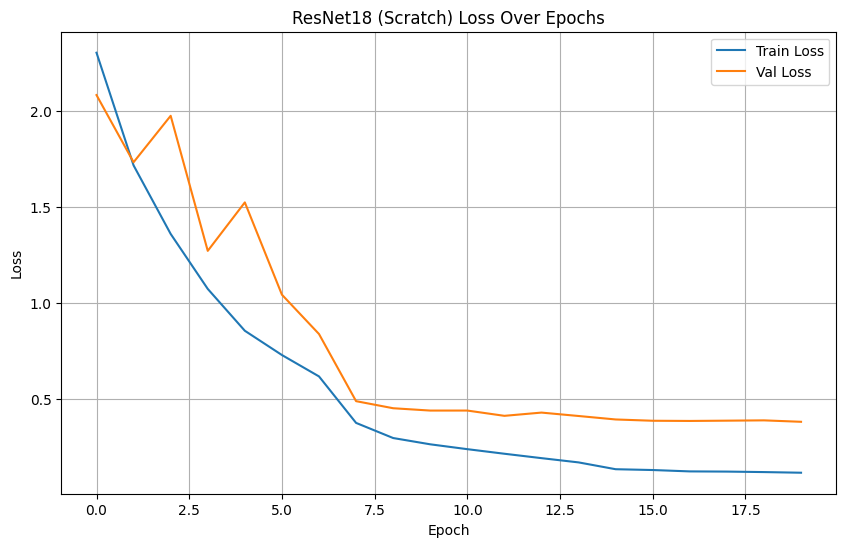

In [27]:
scratch_results = {}

for name, model in scratch_models.items():
    results = train_from_scratch(name, model)
    scratch_results[name] = results


**Training CNN Models from Random Weights Experiment Results:**

In this part, we trained the selected CNN models using *random weights*.

Since the models were not pre-trained, the training process was *expected to take longer*. To avoid hitting the *Colab runtime limit*, we used *only 50% of the dataset*. Also, because the *risk of early stopping was higher* in random training, we increased the *number of epochs to 20*.


**EfficientNet-B0 (Random Weights)**

- The model was trained from scratch for 20 epochs.
- It showed clear improvement in both training and validation loss over time.
- Final test accuracy: **78.19%**
- F1-score: **78.29%**
- The results were close to the pre-trained version, but took **87 minutes** to complete (with half data).

> Comments: EfficientNet-B0 *performed well even with random weights*, though training took longer. It learned gradually and reached good generalization.


**VGG16 (Random Weights)**

- Training stopped early at epoch 8 because of *no improvement in validation loss*.
- Final test accuracy: **4.00%**
- F1-score: **0.31%**
- Training completed in **34 minutes**.

> Comments: VGG16 failed to learn meaningful patterns from scratch. The *model was not able to generalize*, likely due to its *larger size and lack of transfer learning support*.


**ResNet18 Model (Random Weights)**
- The model was trained from scratch for 20 epochs.
- It showed clear improvement in both training and validation loss over time.
- Final test accuracy: **87.84%**
- F1-score: **87.90%**
- The results were close to the pre-trained version, but took **78 minutes** to complete.

> Comments: The model shows a steady decrease in both training and validation loss over 20 epochs, indicating effective learning and good convergence without signs of overfitting or underfitting. Balanced metrics suggest the model generalizes well across different bird species classes.


**Summary**

| Model          | Accuracy | F1-Score | Training Time |
|----------------|----------|----------|----------------|
| EfficientNet-B0 | 78.19%   | 78.29%   | 87 min         |
| VGG16           | 4.00%    | 0.31%    | 34 min         |
| ResNet18           | 87.84%   | 87.90%    | 78 min         |


**Conclusion:**  
Among the three models, *ResNet18 performed the best* with the highest accuracy and F1-score. EfficientNet-B0 showed good results but took longer to train. VGG16 performed poorly in accuracy and F1-score, likely because early stopping was triggered during training. This was probably *due to VGG16 being a large model* trained from random weights, which can cause *difficulties in generalization and slower convergence*.

Also, training from scratch with random weights took about the same time as training with pretrained weights before, even though only 50% of the data was used. This highlights the *importance of using pretrained weights to achieve better performance and faster training*.


# **Part 5: Implementing and Training a CNN Model from Scratch**
Creating our own CNN model with using any library, determining the best layers that fits best to the given dataset. 

**Libraries and variables**

In [15]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# Define relevant variables for the ML task
batch_size = 32
num_classes = 25
learning_rate = 0.001
num_epochs = 20

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Data Transformations**

In [16]:
# Define transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((64, 64)), # scales images to a fixed size (224x224 pixels), necessary for the CNNs to fit the input size
        transforms.RandomHorizontalFlip(), # (training only): randomly flips image horizontally, data augmentation technique, makes model more robust to horizontal variations
        transforms.ToTensor(), # converts image from NumPy array to a PyTorch tensor and normalizes values ​​to the range 0–1
    ]),
    'val': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
}

data_dirs = {
    'train': TRAIN_DIR_80,
    'val': VALID_DIR_10,
    'test': TEST_DIR_10
}
# ImageFolder is a PyTorch ready function. It takes the images in the folder you specify and gives them labels according to the subfolder name.
# Images in a specific folder are taken and then a specific transformation is applied
image_datasets = {x: ImageFolder(data_dirs[x], data_transforms[x]) for x in ['train', 'val', 'test']}

# num_workers: number of threads are used to load data. This speeds up the loading process.
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

train_loader = dataloaders['train']
valid_loader = dataloaders['val']
test_loader = dataloaders['test']

**Model**

In [ ]:
import torch.nn as nn

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()

        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)   # 64x64 → 64x64
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  # 64x64 → 64x64
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 → 32x32

        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)   # 32x32 → 32x32
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)   # 32x32 → 32x32
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 → 16x16

        # Feature map size: 64 channel * 16 * 16 = 16384
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)

        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)  # Flatten
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [18]:
model = ConvNeuralNet(num_classes)

# Move the model to the configured device
model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_loader)

**Base CNN Model Model Structure:**
In this first trial, we created a basic Convolutional Neural Network (CNN) model using PyTorch. The model is designed to classify images into 25 different classes. It was trained using 70% of the dataset, with the following setup:

- Batch size: 32
- Learning rate: 0.001
- Epochs: 20
- Optimizer: SGD with momentum and weight decay
- Loss Function: CrossEntropyLoss

**The architecture of the model includes:**

- Two convolutional layers with 32 filters, followed by a max-pooling layer
- Two more convolutional layers with 64 filters, followed by another max-pooling layer
- A fully connected (linear) layer with 128 neurons
- An output layer with 25 neurons (one for each class)

This structure is simple and provides a starting point for understanding how well a basic CNN performs on the dataset.

**Training**

Epoch [1/20]
Train Loss: 2.8117 | Val Loss: 2.7084
Epoch [2/20]
Train Loss: 2.6217 | Val Loss: 2.5553
Epoch [3/20]
Train Loss: 2.4671 | Val Loss: 2.3904
Epoch [4/20]
Train Loss: 2.3122 | Val Loss: 2.3081
Epoch [5/20]
Train Loss: 2.2250 | Val Loss: 2.2540
Epoch [6/20]
Train Loss: 2.1534 | Val Loss: 2.2806
Epoch [7/20]
Train Loss: 2.0817 | Val Loss: 2.1789
Epoch [8/20]
Train Loss: 2.0120 | Val Loss: 2.1900
Epoch [9/20]
Train Loss: 1.9408 | Val Loss: 2.0882
Epoch [10/20]
Train Loss: 1.8641 | Val Loss: 2.0742
Epoch [11/20]
Train Loss: 1.7928 | Val Loss: 2.0823
Epoch [12/20]
Train Loss: 1.7161 | Val Loss: 2.0273
Epoch [13/20]
Train Loss: 1.6294 | Val Loss: 2.0239
Epoch [14/20]
Train Loss: 1.5437 | Val Loss: 2.0266
Epoch [15/20]
Train Loss: 1.4444 | Val Loss: 1.9755
Epoch [16/20]
Train Loss: 1.3445 | Val Loss: 1.9978
Epoch [17/20]
Train Loss: 1.2626 | Val Loss: 2.0256
Epoch [18/20]
Train Loss: 1.1664 | Val Loss: 1.9957
Epoch [19/20]
Train Loss: 1.0815 | Val Loss: 2.0618
Epoch [20/20]
Train L

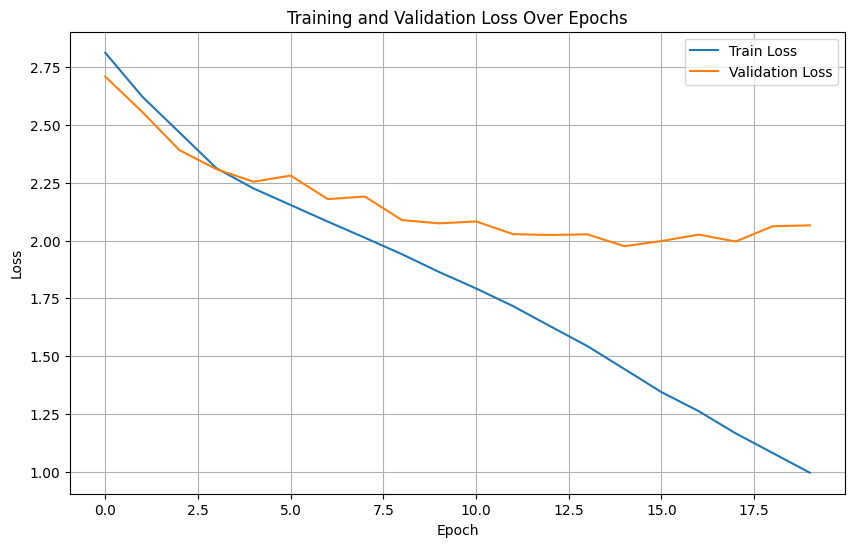

In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
import time
import matplotlib.pyplot as plt 

start_time = time.time() # Record the start time

train_losses = [] # List to store training loss per epoch
val_losses = []   # List to store validation loss per epoch

for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    print('Epoch [{}/{}]'.format(epoch+1, num_epochs))

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0) # Accumulate loss

    epoch_train_loss = running_train_loss / len(train_loader.dataset) # Calculate average train loss
    train_losses.append(epoch_train_loss)

    # Validation Phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in valid_loader: # Use valid_loader for validation
            images = images.to(device)
            labels = labels.to(device)
            #print(f"val{i}")

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0) # Accumulate loss

    epoch_val_loss = running_val_loss / len(valid_loader.dataset) # Calculate average validation loss
    val_losses.append(epoch_val_loss)

    print(f'Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}')

end_time = time.time() # Record the end time
total_training_time = end_time - start_time # Calculate the total time

print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Testing on Test Dataset**

Accuracy of the network on the test images: 41.48571428571429 %
Accuracy of the network on the test images: 41.48571428571429 %
Precision on the test images: 0.42
Recall on the test images: 0.41
F1-Score on the test images: 0.41


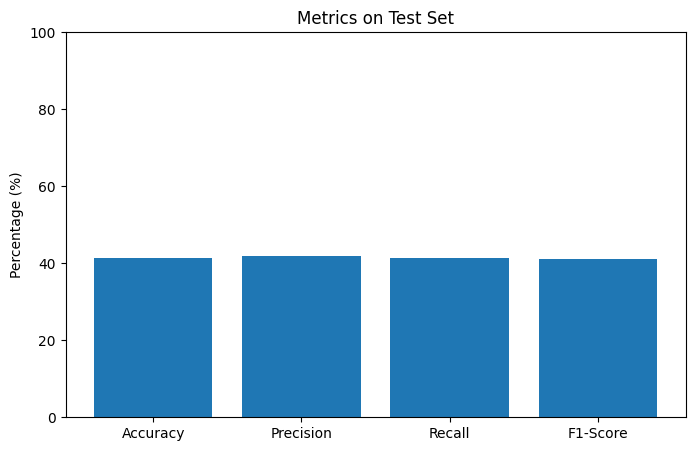

Test time: 8.17 seconds


In [25]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch

start_time_eval = time.time() # Start timer for evaluation
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predicted, average='weighted', zero_division=0)

    print('Accuracy of the network on the test images: {} %'.format(accuracy))
    print('Precision on the test images: {:.2f}'.format(precision))
    print('Recall on the test images: {:.2f}'.format(recall))
    print('F1-Score on the test images: {:.2f}'.format(f1))

    # Plotting the metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision * 100, recall * 100, f1 * 100]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values)
    plt.ylabel('Percentage (%)')
    plt.title('Metrics on Test Set')
    plt.ylim(0, 100)
    plt.show()

end_time_eval = time.time() # End timer for evaluation
test_time = end_time_eval - start_time_eval # Calculate elapsed time
print(f"Test time: {test_time:.2f} seconds") # Print elapsed time

**Base CNN Model Evaluation:**

**Training and Validation Loss**
The model was trained for 20 epochs. The training loss consistently decreased, which shows that the *model was learning* from the training data. However, the validation loss decreased at first and then stayed nearly the same after a certain point:

- Initial Validation Loss (Epoch 1): 2.7084
- Lowest Validation Loss (Epoch 15): 1.9755
- Final Validation Loss (Epoch 20): 2.0656

This suggests that the model *may be overfitting* to the training data after around epoch 15.

**Performance on Test Data**
After training, the model was evaluated on the test dataset. The results are:

- Test Accuracy: 41.49%
- Precision: 0.42
- Recall: 0.41
- F1-Score: 0.41

These values show that the base model gives moderate performance but is not strong enough for real use. Since the accuracy is slightly above random guessing (for 25 classes, random accuracy is ~4%), it proves the *model is learning, but it needs improvements in architecture or hyperparameters*.

### **Improvements and Modifications for Higher Accuracy Rates**

**Model**

In [17]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return x


In [ ]:
model = ConvNeuralNet(num_classes)

# Move the model to the configured device
model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0005)

total_step = len(train_loader)

**Comparison: Old vs. New Model**

| Aspect                     | Old Model                        | New Model (Improved)                 |
|---------------------------|----------------------------------|-------------------------------------|
| Convolutional Layers      | 2 Conv blocks                    | 3 Conv blocks                       |
| Normalization             | Not used                         | BatchNorm2d added after each Conv |
| Dropout                   | Not used                         | Dropout(0.5) added before FC      |
| Activation                | ReLU used                      | ReLU + BatchNorm2d              |
| Fully Connected (FC)      | 1 FC layer                       | 2 FC layers (fc1, fc2)          |
| Optimizer                 | SGD          | Adam        |
| Dataset Used              | Small subset                     | Full dataset                        |


**Changes and Why:**

- Added One More Convolutional Block: Added conv_block3 to capture deeper patterns and features.
→ Helps the model learn more complex representations.

- Added BatchNorm2d After Each Convolution: Normalizes the output of conv layers.
→ Makes training faster and more stable by reducing internal covariate shift.

- Added Dropout Before Fully Connected Layers: Prevents overfitting by randomly disabling neurons during training.
→ Helps generalize better to validation and test data.

- Used Full Dataset: Training on the complete dataset instead of a smaller subset.
→ Improves the model’s ability to learn from more examples, boosting accuracy.

- Added Weight Decay in Adam Optimizer: Helps prevent overfitting by penalizing large weights.
→ Makes the model more regularized and generalizable.

- Improved Fully Connected Layers: Used fc1 and fc2 instead of just one FC layer.
→ Helps the model transition more effectively from spatial features to class scores.

**Training**

Epoch [1/20]
Train Loss: 0.7951 | Val Loss: 0.9555
Epoch [2/20]
Train Loss: 0.7645 | Val Loss: 0.8527
Epoch [3/20]
Train Loss: 0.7427 | Val Loss: 0.8923
Epoch [4/20]
Train Loss: 0.7211 | Val Loss: 0.9960
Epoch [5/20]
Train Loss: 0.7058 | Val Loss: 0.8108
Epoch [6/20]
Train Loss: 0.6827 | Val Loss: 0.8096
Epoch [7/20]
Train Loss: 0.6681 | Val Loss: 0.8467
Epoch [8/20]
Train Loss: 0.6584 | Val Loss: 0.7900
Epoch [9/20]
Train Loss: 0.6404 | Val Loss: 0.7964
Epoch [10/20]
Train Loss: 0.6236 | Val Loss: 0.8176
Epoch [11/20]
Train Loss: 0.6162 | Val Loss: 0.8450
Epoch [12/20]
Train Loss: 0.6021 | Val Loss: 0.8043
Epoch [13/20]
Train Loss: 0.5962 | Val Loss: 0.7862
Epoch [14/20]
Train Loss: 0.5838 | Val Loss: 0.7789
Epoch [15/20]
Train Loss: 0.5707 | Val Loss: 0.7667
Epoch [16/20]
Train Loss: 0.5741 | Val Loss: 0.7638
Epoch [17/20]
Train Loss: 0.5651 | Val Loss: 0.7775
Epoch [18/20]
Train Loss: 0.5618 | Val Loss: 0.7435
Epoch [19/20]
Train Loss: 0.5572 | Val Loss: 0.7304
Epoch [20/20]
Train L

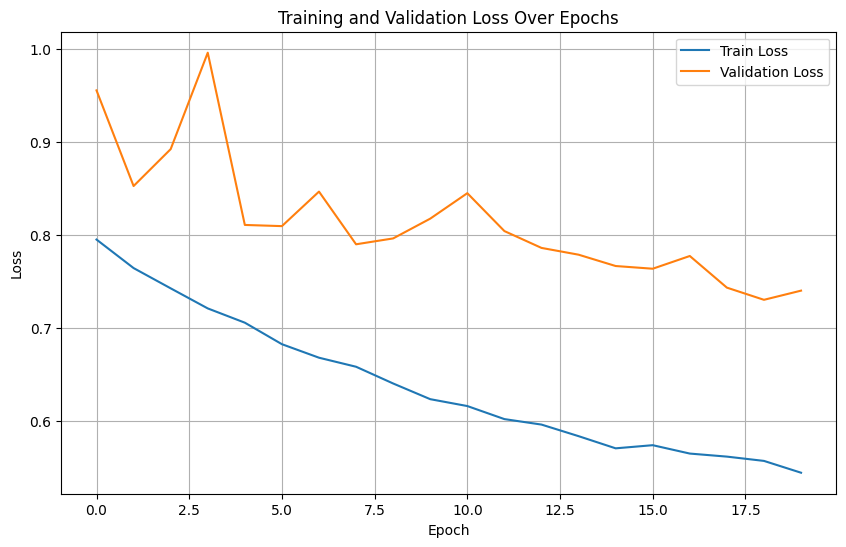

In [ ]:
# We use the pre-defined number of epochs to determine how many iterations to train the network on
import time
import matplotlib.pyplot as plt # Import matplotlib

start_time = time.time() # Record the start time

train_losses = [] # List to store training loss per epoch
val_losses = []   # List to store validation loss per epoch

for epoch in range(num_epochs):
    # Training Phase
    model.train() # Set model to training mode
    running_train_loss = 0.0
    print('Epoch [{}/{}]'.format(epoch+1, num_epochs))

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * images.size(0) # Accumulate loss

    epoch_train_loss = running_train_loss / len(train_loader.dataset) # Calculate average train loss
    train_losses.append(epoch_train_loss)

    # Validation Phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for validation
        for images, labels in valid_loader: # Use valid_loader for validation
            images = images.to(device)
            labels = labels.to(device)
            #print(f"val{i}")

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0) # Accumulate loss

    epoch_val_loss = running_val_loss / len(valid_loader.dataset) # Calculate average validation loss
    val_losses.append(epoch_val_loss)

    print(f'Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}')

end_time = time.time() # Record the end time
total_training_time = end_time - start_time # Calculate the total time

print(f"\nTotal training time: {total_training_time:.2f} seconds")

# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Testing on Test Dataset**

Accuracy of the network on the test images: 77.09333333333333 %
Accuracy of the network on the test images: 77.09333333333333 %
Precision on the test images: 0.79
Recall on the test images: 0.77
F1-Score on the test images: 0.77


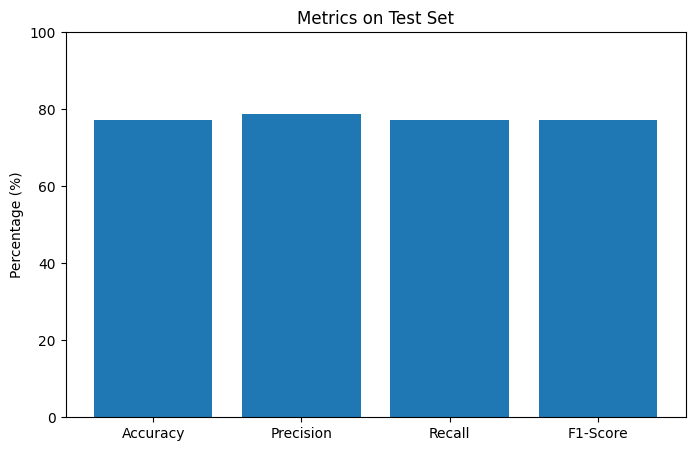

Test time: 9.19 seconds


In [24]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import torch

start_time_eval = time.time() # Start timer for evaluation
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predicted = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_predicted, average='weighted', zero_division=0)

    print('Accuracy of the network on the test images: {} %'.format(accuracy))
    print('Precision on the test images: {:.2f}'.format(precision))
    print('Recall on the test images: {:.2f}'.format(recall))
    print('F1-Score on the test images: {:.2f}'.format(f1))

    # Plotting the metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    values = [accuracy, precision * 100, recall * 100, f1 * 100]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values)
    plt.ylabel('Percentage (%)')
    plt.title('Metrics on Test Set')
    plt.ylim(0, 100)
    plt.show()

end_time_eval = time.time() # End timer for evaluation
test_time = end_time_eval - start_time_eval # Calculate elapsed time
print(f"Test time: {test_time:.2f} seconds") # Print elapsed time

**New Model Training Performance**
- Train Loss decreased steadily from 0.7951 to 0.5445.
- Validation Loss decreased from 0.9555 to 0.7402 by the final epoch.

Shows *no major overfitting*, which means *our regularization choices (Dropout + BatchNorm + Weight Decay) worked well*.

**Final Test Results**
- Test Accuracy: 77.09%
- Precision: 0.79
- Recall: 0.77
- F1-Score: 0.77

Total Training Time: 2039.94 seconds (~34 minutes)

These metrics indicate our model is *now performing significantly better than the previous version*, especially in *generalization to unseen test data*.

## **Final Comparison Table**

| Part | Model              | Pretrained | Dataset Size | Epochs | Accuracy | F1-Score | Training Time       | Key Notes                              |
|------|--------------------|------------|--------------|--------|----------|----------|----------------------|-----------------------------------------|
| 3.1  | ResNet18           | Yes        | 50%          | 20     | 96.96%   | 96.9%    | 77 min               | Very high performance with fine-tuning  |
| 3.1  | VGG16              | Yes        | 50%          | 20     | 83.09%   | 83.28%   | 86 min               | Acceptable performance                  |
| 3.1  | EfficientNet-B0    | Yes        | 50%          | 20     | -        | -        | -                    | Gave an error                           |
| 3.2  | EfficientNet-B0    | Yes        | 100%         | 10     | 99.28%   | -        | 82 min 21 sec        | Highest accuracy overall                |
| 3.2  | ResNet18           | Yes        | 100%         | 10     | 97.71%   | -        | 79 min 28 sec        | Consistent and fast                     |
| 3.2  | VGG16              | Yes        | 100%         | 10     | 92.53%   | -        | 106 min 12 sec       | Weaker than others                      |
| 4    | EfficientNet-B0    | No         | 50%          | 20     | 78.19%   | 78.29%   | 87 min               | Significant drop without pretraining    |
| 4    | VGG16              | No         | 50%          | 20     | 4.00%    | 0.31%    | 34 min               | Failed to learn                         |
| 4    | ResNet18           | No         | 50%          | 20     | 87.84%   | 87.90%   | 78 min               | Performed well even without pretraining |
| 5.1  | Our Base Model     | No         | 70%          | 20     | 41.49%   | 0.41     | 22 min 27 sec        | Poor generalization                     |
| 5.2  | Our Final Model    | No         | 100%         | 20     | 77.09%   | 0.77     | 34 min               | Good performance for custom model       |


## **Summary**
In this project, we tested different CNN models in different ways. When we used pretrained models like EfficientNet-B0 and ResNet18, the results were very high—especially EfficientNet-B0 with 99.28% accuracy when trained on the full dataset. Pretrained models clearly helped a lot.

When we removed the pretrained weights and used random initialization (Part 4), the performance dropped. For example, ResNet18 still did well (87.84%) but others like VGG16 almost failed to learn (only 4% accuracy). This shows how important pretrained weights are.

Finally, we created our own CNN models (Part 5). In the first trial with 70% data, our base model gave poor results (41%). But after improvements and using the full dataset, our new model reached 77% accuracy. While not as high as pretrained models, it's still a good result for a custom model.

In conclusion, pretrained models work best, especially when we use more data. But it was also helpful to design and train our own models from scratch to understand the architecture and training process better.